In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import os
import scipy.stats
import tqdm.notebook
import h5py
import celltypist
import pickle
import torch

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

[rank: 0] Global seed set to 0


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


### Define paths and constants

In [44]:
base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/"

in_path = base_path
cache_path = os.path.join(base_path, "covid_flu_cache.h5ad")
out_path = os.path.join(base_path, "processed", "covid_flu_processed_reduced_genes.h5")
vae_model_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d200/"

celltypist_model_path = "/gstore/home/tsenga5/branched_diffusion/data/scrna/celltypist_models/Immune_All_Low.pkl"

In [3]:
cluster_markers_dir = os.path.join(base_path, "cluster_markers")
go_term_genes_dir = os.path.join(base_path, "go_term_genes")
cluster_module_genes_path = os.path.join(base_path, "cluster_expression_modules.csv")
tcell_genes_dir = os.path.join(base_path, "non_em_like_cd8_t_cell_subcluster_genes")
cm_genes_path = os.path.join(base_path, "classical_monocyte_subcluster_genes.csv")
covid_genes_dir = os.path.join(base_path, "covid_genes")

### Import data

In [4]:
adata = sc.read_10x_mtx(
    in_path, prefix="GSE149689_", var_names="gene_symbols", cache=True
)
adata.var_names_make_unique()
adata

... reading from cache file cache/gstore-data-resbioai-tsenga5-branched_diffusion-data-scrna-covid_flu-GSE149689_matrix.h5ad


AnnData object with n_obs × n_vars = 85144 × 33538
    var: 'gene_ids', 'feature_types'

In [5]:
cluster_marker_tables = []
file_names = sorted(os.listdir(cluster_markers_dir), key=(lambda k: int(k.split(".")[0].split("_")[1])))
for file_name in file_names:
    cluster_marker_tables.append(
        pd.read_csv(os.path.join(cluster_markers_dir, file_name), sep=",", header=0)
    )
        
go_term_gene_tables = {}
for file_name in os.listdir(go_term_genes_dir):
    go_term_gene_tables[file_name[:-4]] = pd.read_csv(
        os.path.join(go_term_genes_dir, file_name), sep=",", header=0
    )
    
cluster_module_genes_table = pd.read_csv(cluster_module_genes_path, sep=",", header=0)

tcell_genes_tables = []
file_names = sorted(os.listdir(tcell_genes_dir), key=(lambda k: int(k.split(".")[0].split("_")[1])))
for file_name in file_names:
    tcell_genes_tables.append(
        pd.read_csv(os.path.join(tcell_genes_dir, file_name), sep=",", header=0)
    )
    
cm_genes_table = pd.read_csv(cm_genes_path, sep=",", header=0)

covid_genes_tables = {}
for file_name in os.listdir(covid_genes_dir):
    covid_genes_tables[file_name[:-4]] = pd.read_csv(
        os.path.join(covid_genes_dir, file_name), sep=",", header=0
    )

In [6]:
text_genes = ["CCL3", "CCL4", "CCL5", "CD27", "CREM", "CXCL10", "CXCL2", "CXCR3", "GBP1", "GNLY", "GZMA", "GZMB", "GZMH", "GZMK", "HBA1", "HBA2", "HBB", "IFITM1", "IFITM2", "IFITM3", "IFNG", "IL1B", "IL6", "IRF1", "IRF3", "ISG15", "ISG20", "JAK3", "JUN", "MR1", "NFKB1", "NFKB2", "NFKBID", "OAS1", "OSM", "PPBP", "PRF1", "PSMB9", "PSME2", "RGS1", "RGS10", "RPS18", "SELL", "STAT1", "STAT4", "TAP1", "TGFB1", "TLR4", "TNF"]

### Pre-processing 1: initial filtering

normalizing counts per cell
    finished (0:00:00)


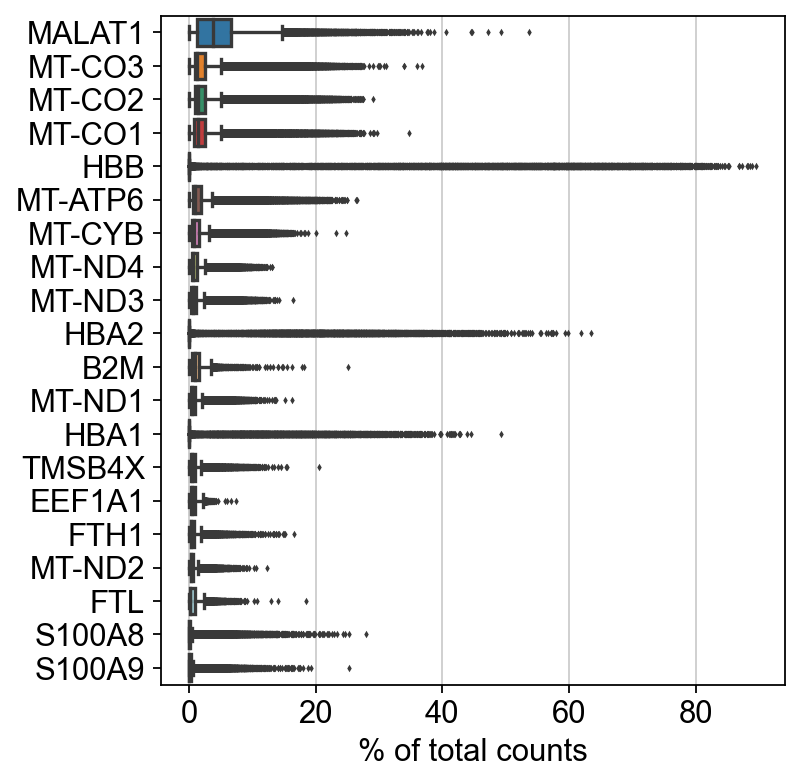

In [7]:
# Plot highest-expression genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# Filter out cells with too few genes and genes with too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 8615 cells that have less than 200 genes expressed
filtered out 10227 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 76529 × 23311
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

... storing 'feature_types' as categorical


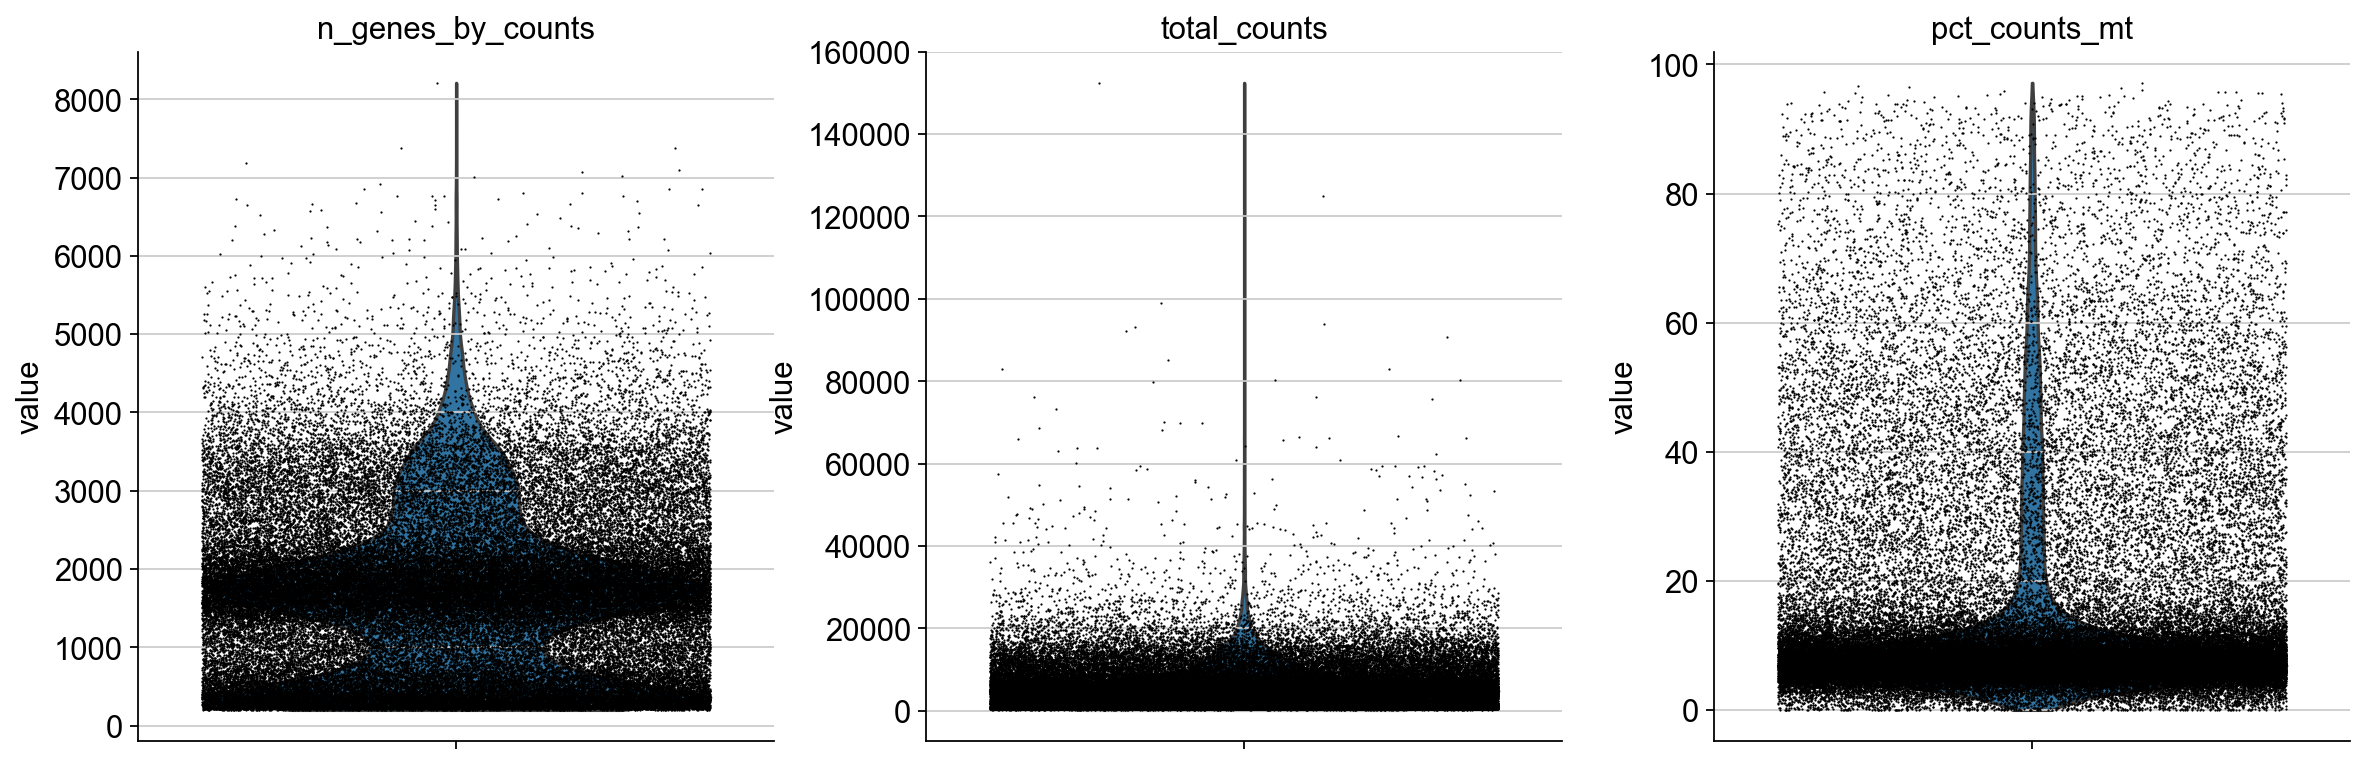

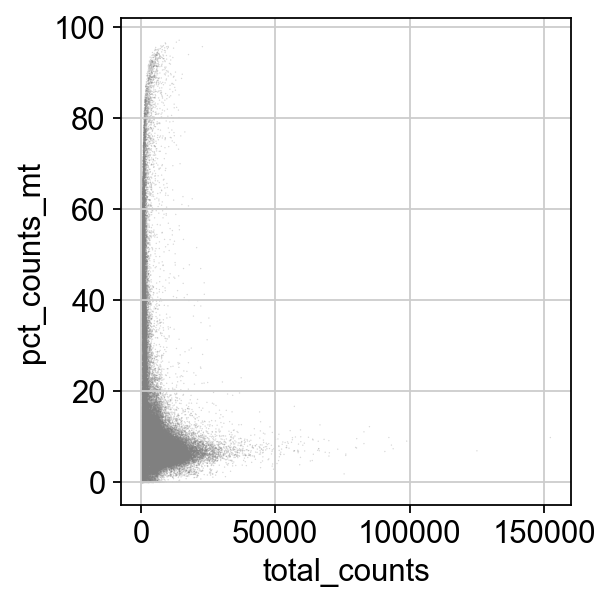

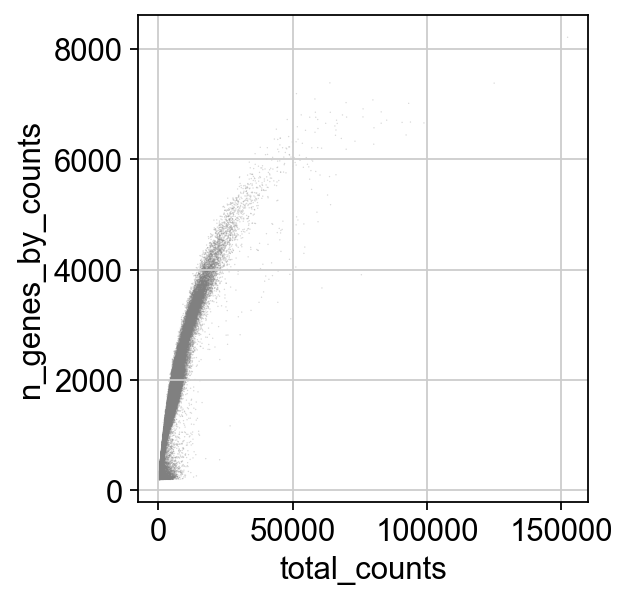

View of AnnData object with n_obs × n_vars = 37102 × 23311
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:
# Filter out cells with too many mitochondrial genes or too many total counts

adata.var["mt"] = adata.var_names.str.startswith("MT-")  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", alpha=0.3)
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", alpha=0.3)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

### Pre-processing 2: assign cell-type labels

In [10]:
# Save a copy of current data (before normalization)
adata.raw = adata

In [11]:
# Normalize total counts to 10000, and turn to log-scale
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [12]:
# Assign each cell a cell type using celltypist

# Import the fine-grained celltypist model
with open(celltypist_model_path, "rb") as f:
    obj = pickle.load(f)
    model = celltypist.models.Model(obj["Model"], obj["Scaler_"], obj["description"])
    
predictions = celltypist.annotate(
    adata, model=model, majority_voting=True
)

adata = predictions.to_adata()

🔬 Input data has 37102 cells and 23311 genes
🔗 Matching reference genes in the model
🧬 5745 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering


filtered out 2984 genes that are detected in less than 5 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


⛓️ Over-clustering input data with resolution set to 15


running Leiden clustering
    finished: found 228 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:07)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [13]:
adata.obs["cell_cluster"] = adata.obs.loc[
    adata.obs.index, "majority_voting"
]

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_cluster']`


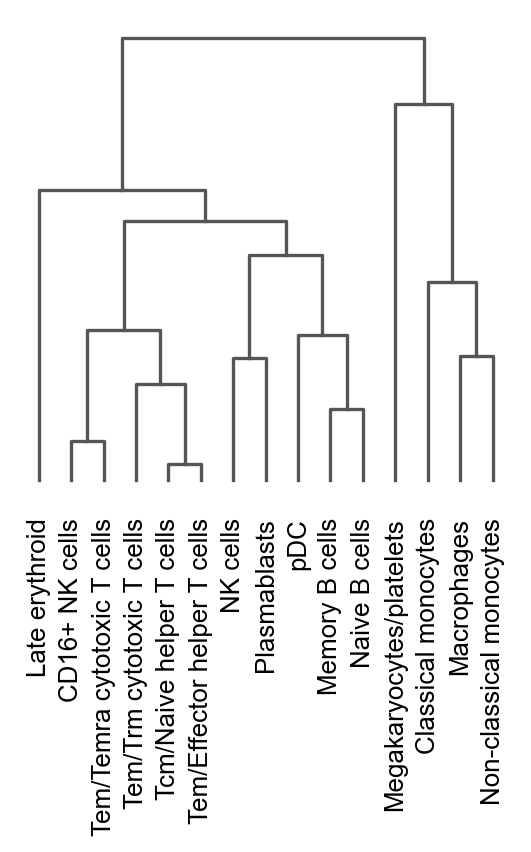

<AxesSubplot:>

In [14]:
# Visualize hierarchy
sc.pl.dendrogram(adata, groupby="cell_cluster")

### Pre-processing 3: select highly variable genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


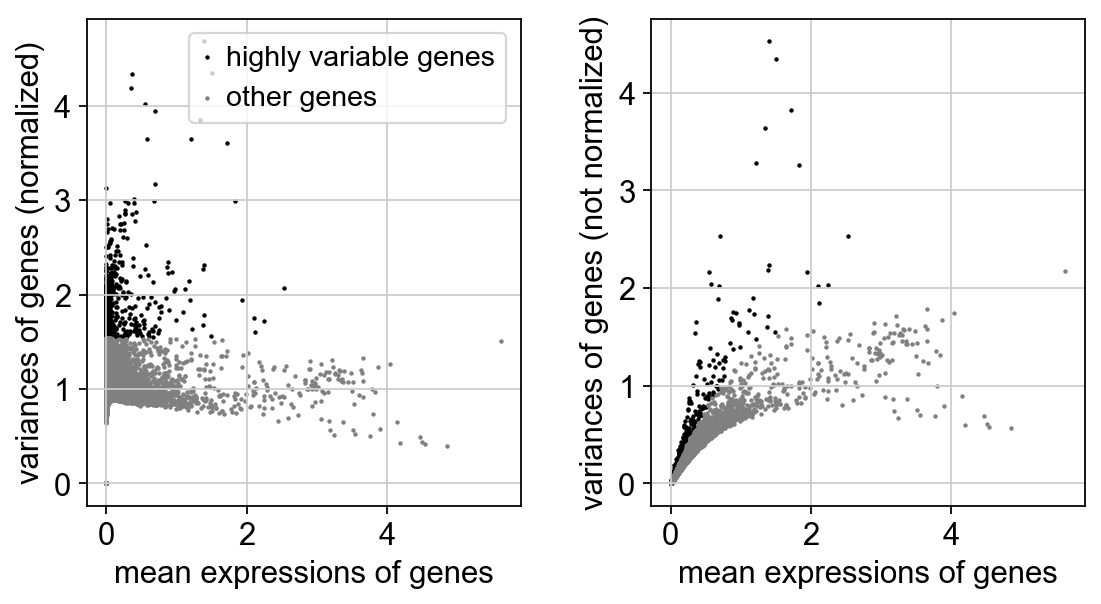

View of AnnData object with n_obs × n_vars = 37102 × 1000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'dendrogram_cell_cluster', 'hvg'
    obsm: 'X_pca'
    obsp: 'connectivities', 'distances'

In [15]:
# Keep only highly variable genes
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor="seurat_v3")
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
adata

In [16]:
# Scale to unit variance and cut off anything outside 10 standard deviations
sc.pp.scale(adata, max_value=10, zero_center=False)

... be careful when using `max_value` without `zero_center`.


### Clustering

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


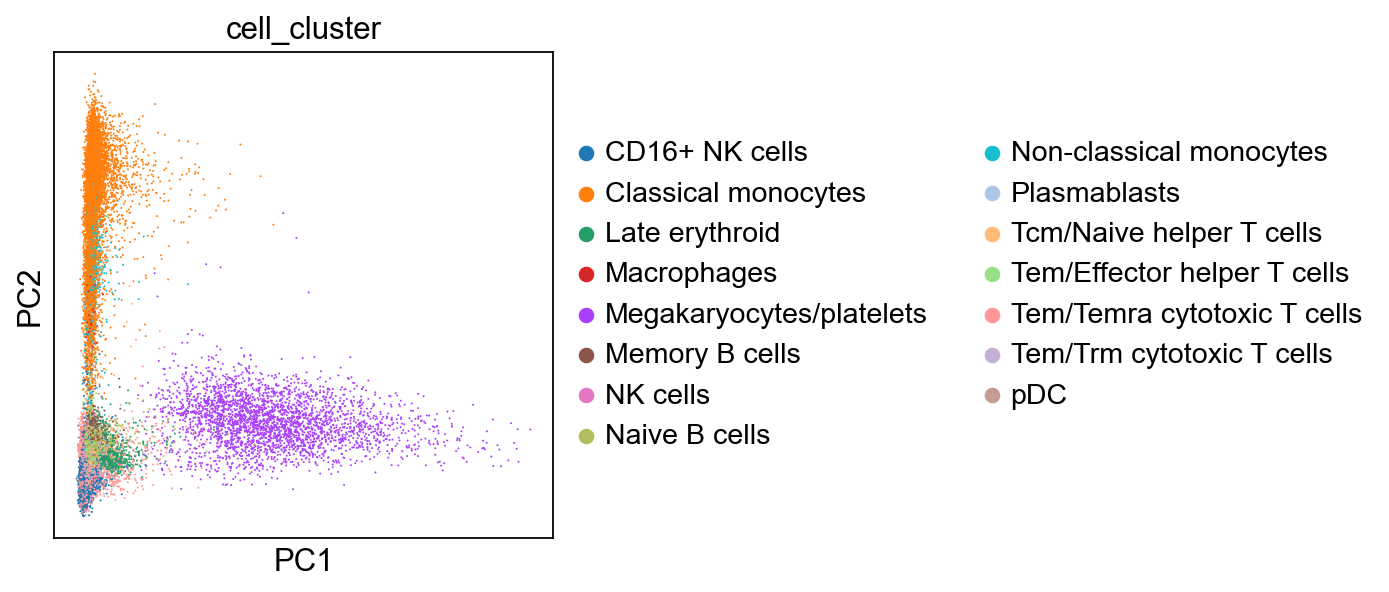

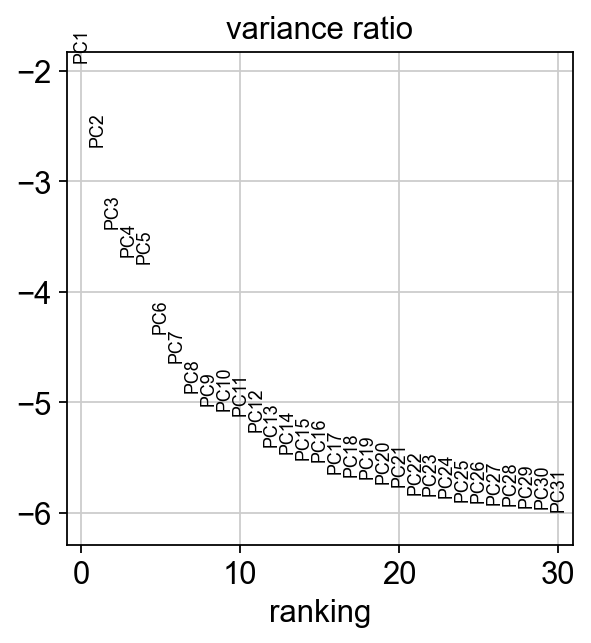

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [17]:
# Compute neighborhood graph on PC-reduced representations
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca(adata, color="cell_cluster")
sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [18]:
# Compute UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


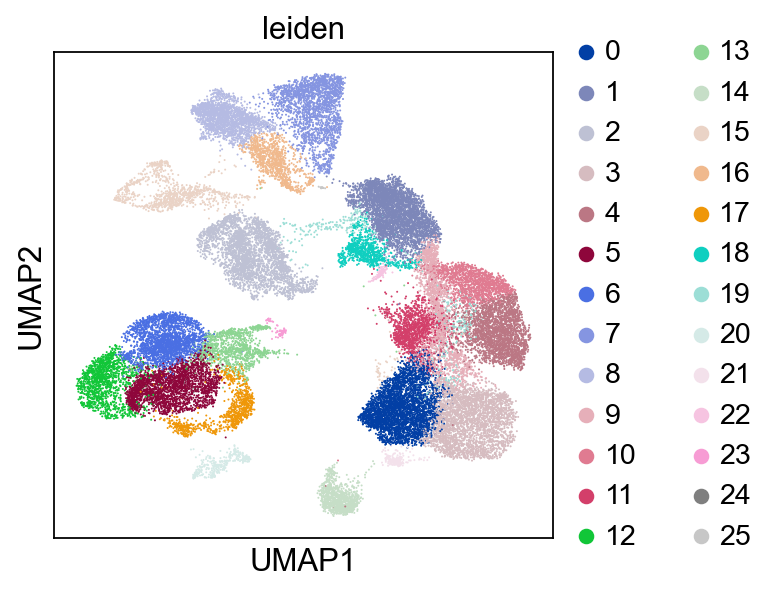

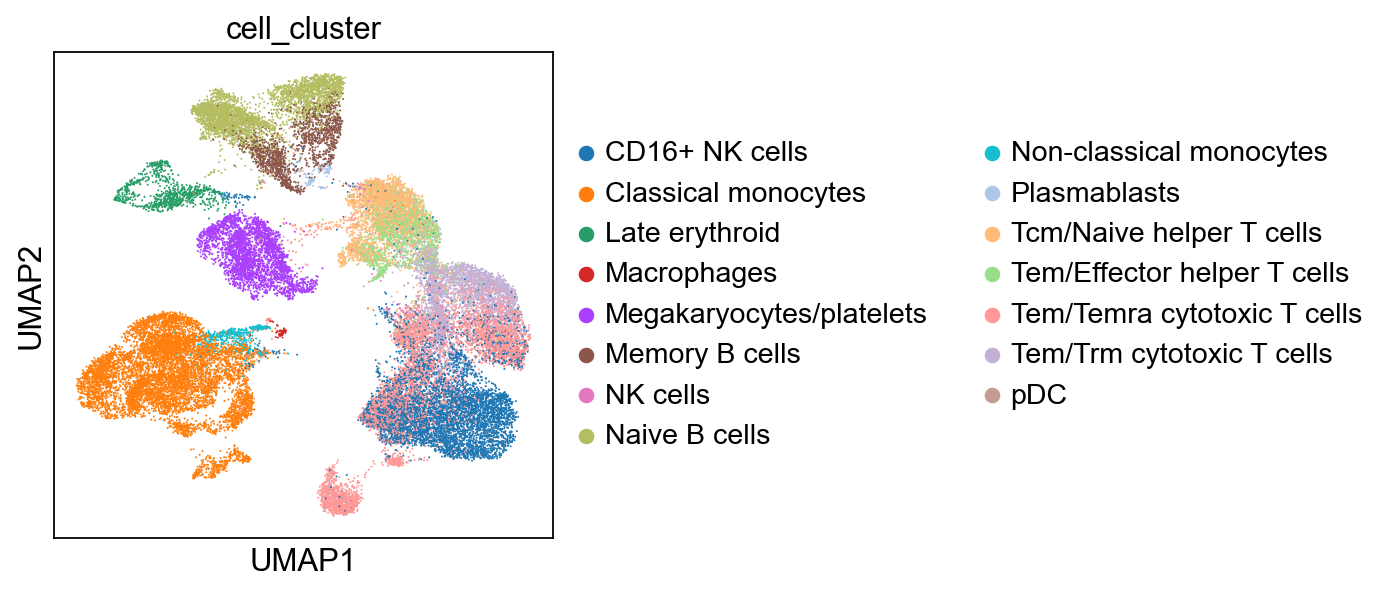

In [19]:
# Plot UMAP, coloring by Leiden clusters and by mapped clusters
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")
sc.pl.umap(adata, color="cell_cluster")

### View feature distributions

In [20]:
# Extract out raw counts, limited to the reduced gene set
inds = np.empty(len(adata.var_names), dtype=int)
for i, g in enumerate(adata.var_names):
    inds[i] = np.where(adata.raw.var_names == g)[0][0]
raw_counts = adata.raw.X[:, inds].toarray()

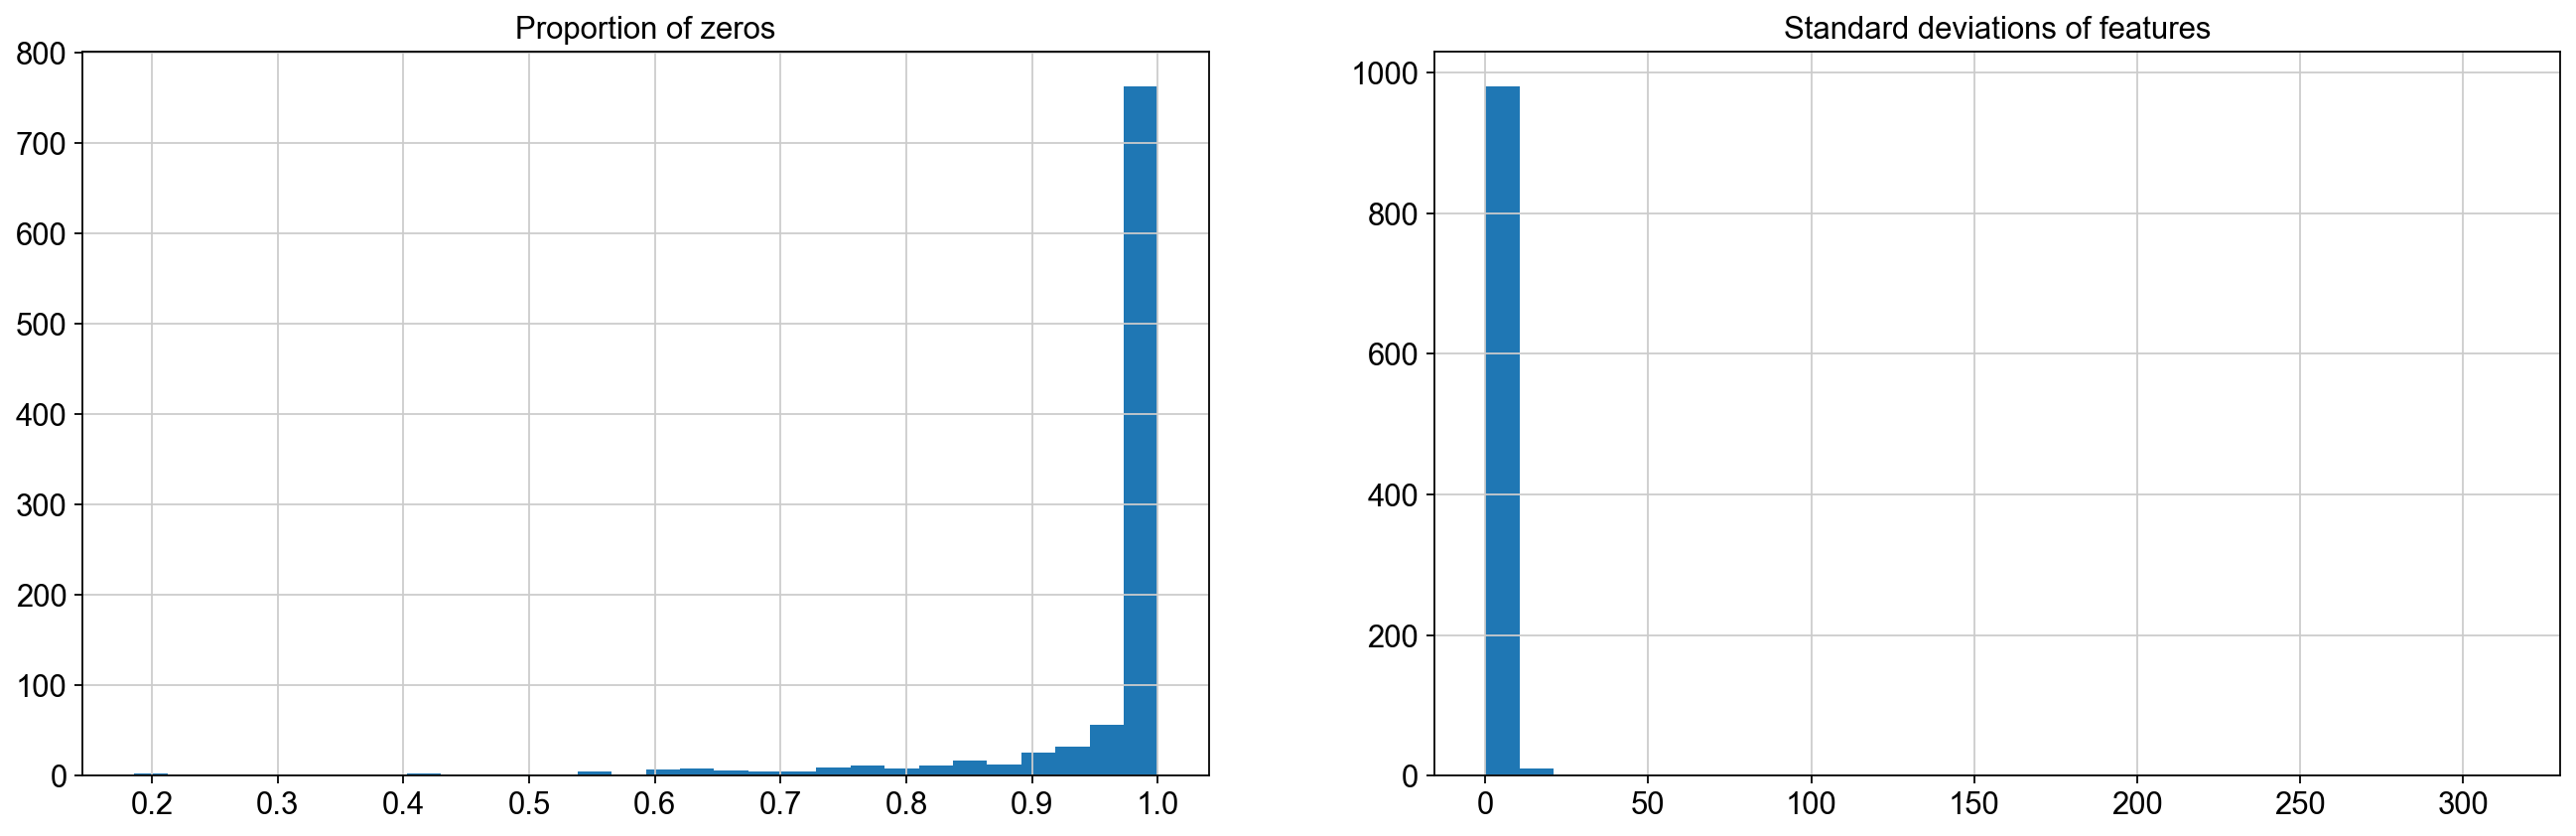

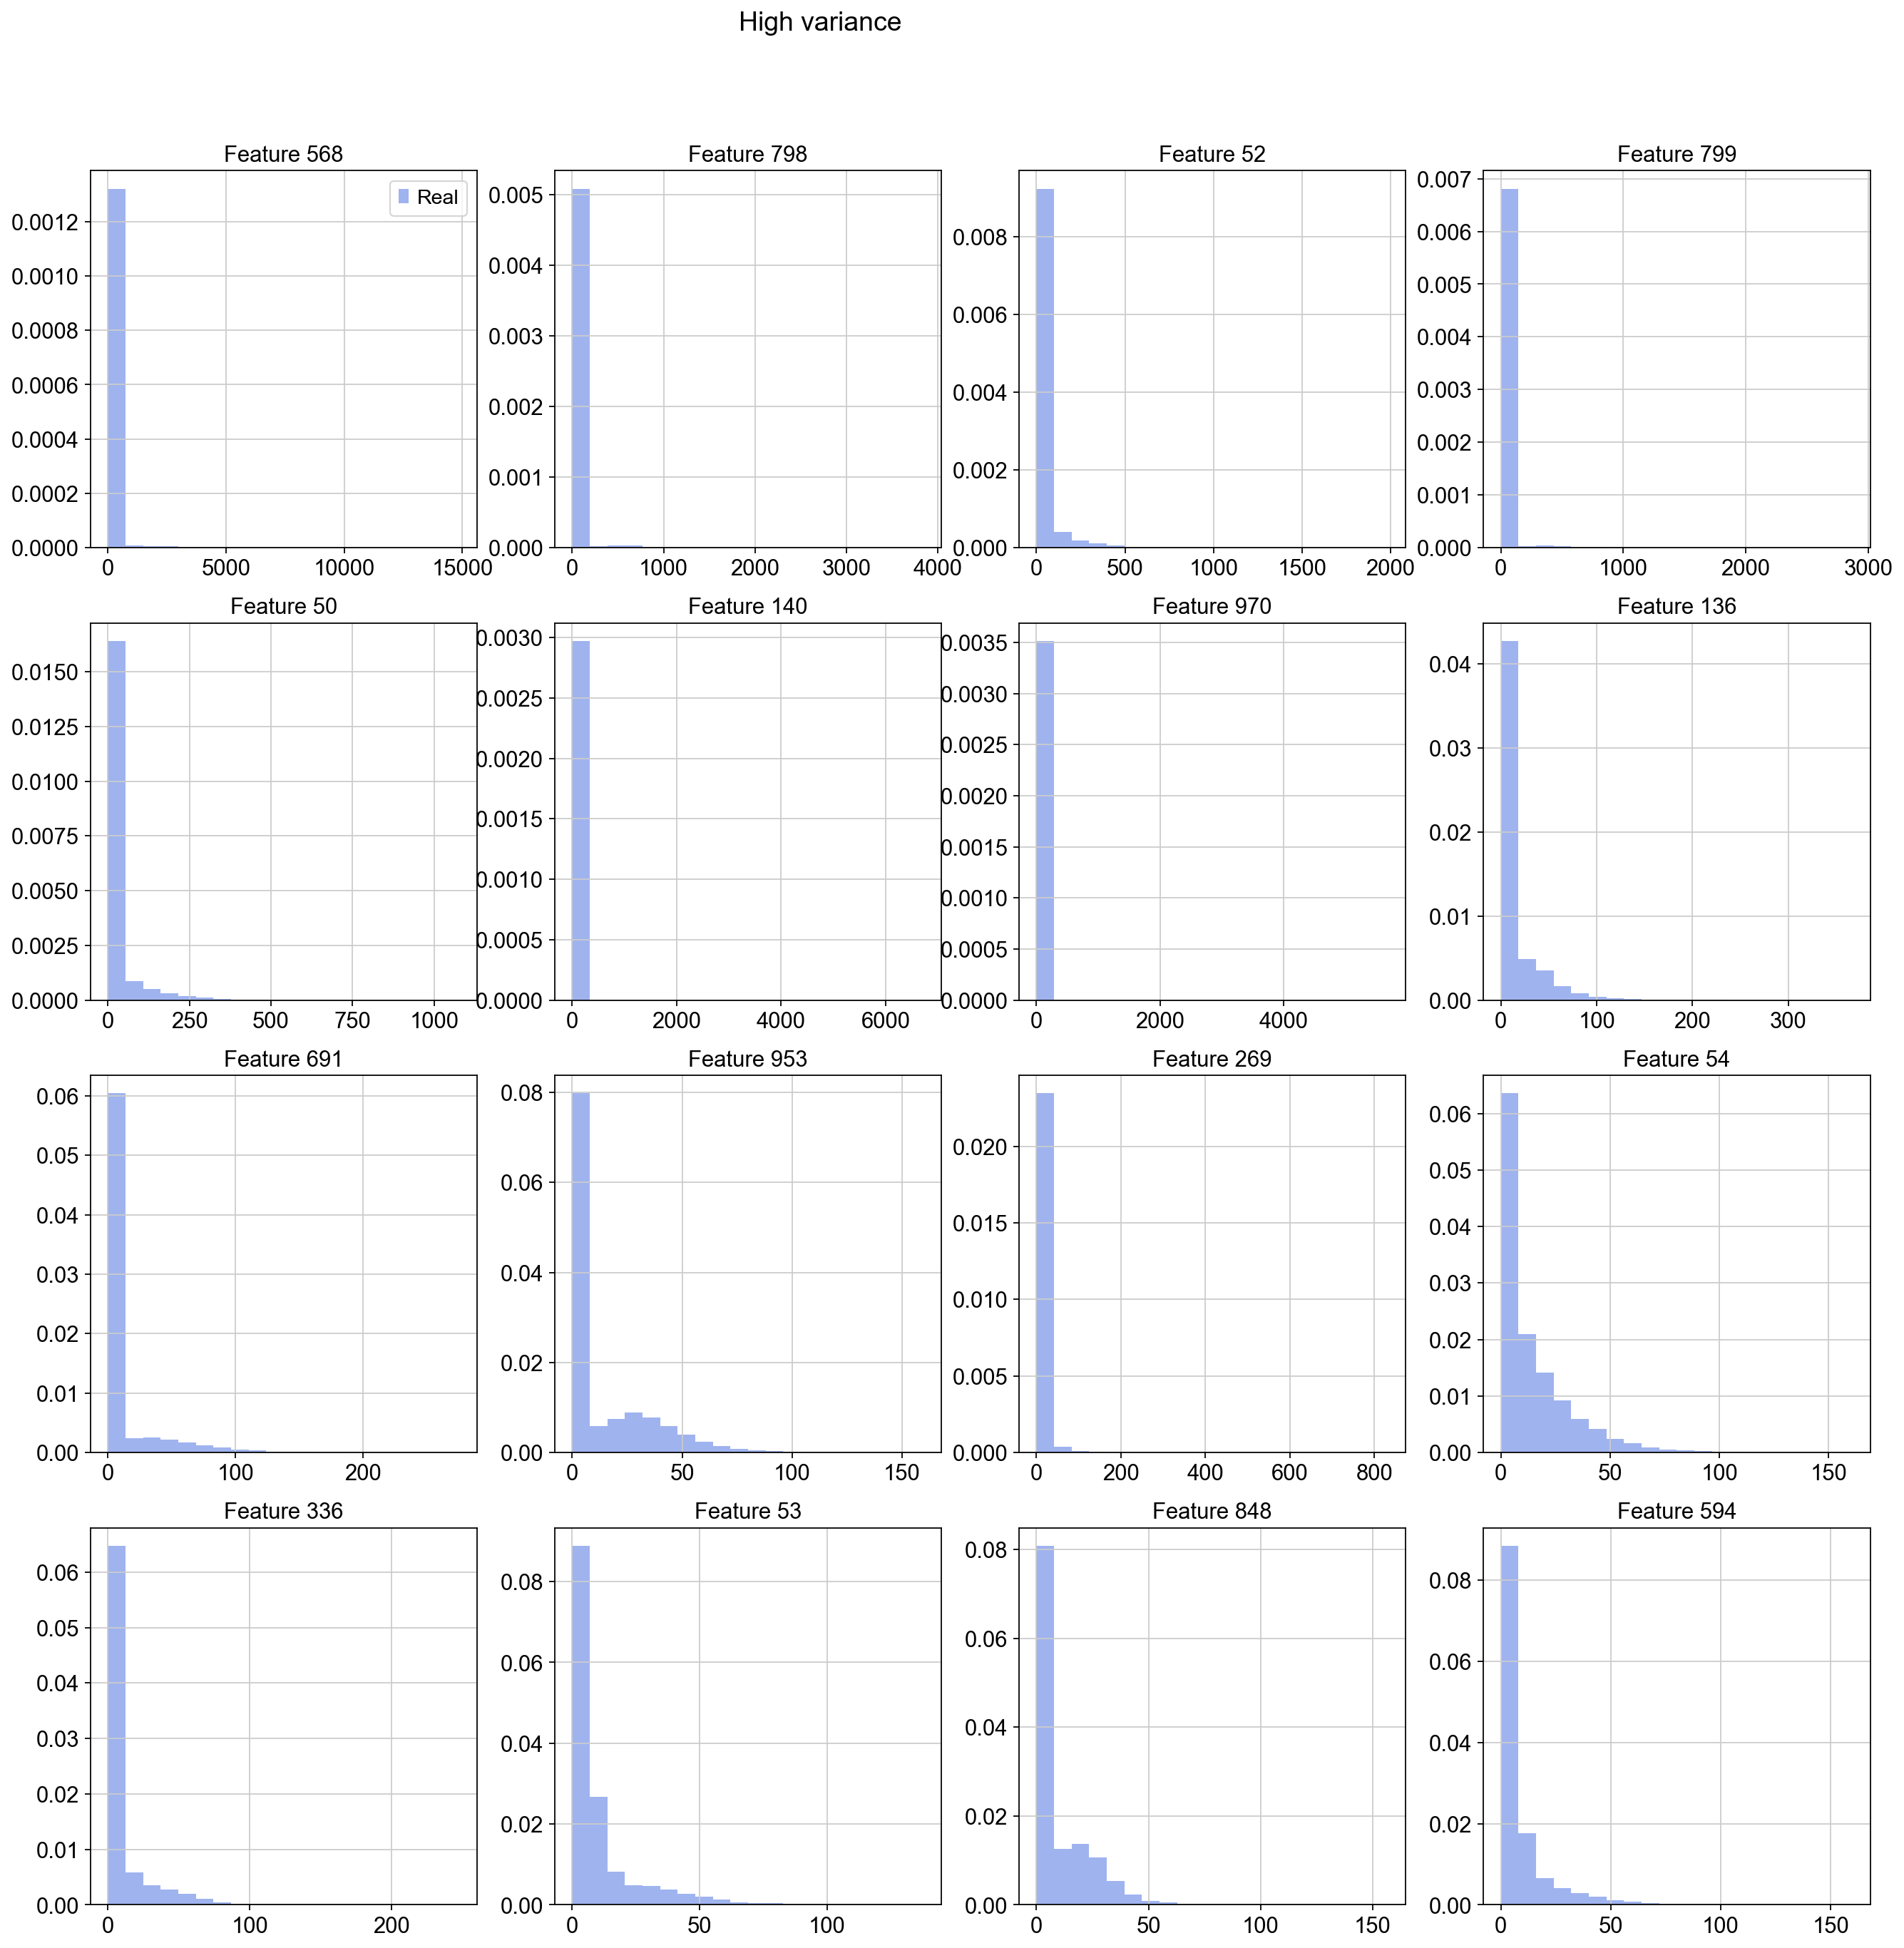

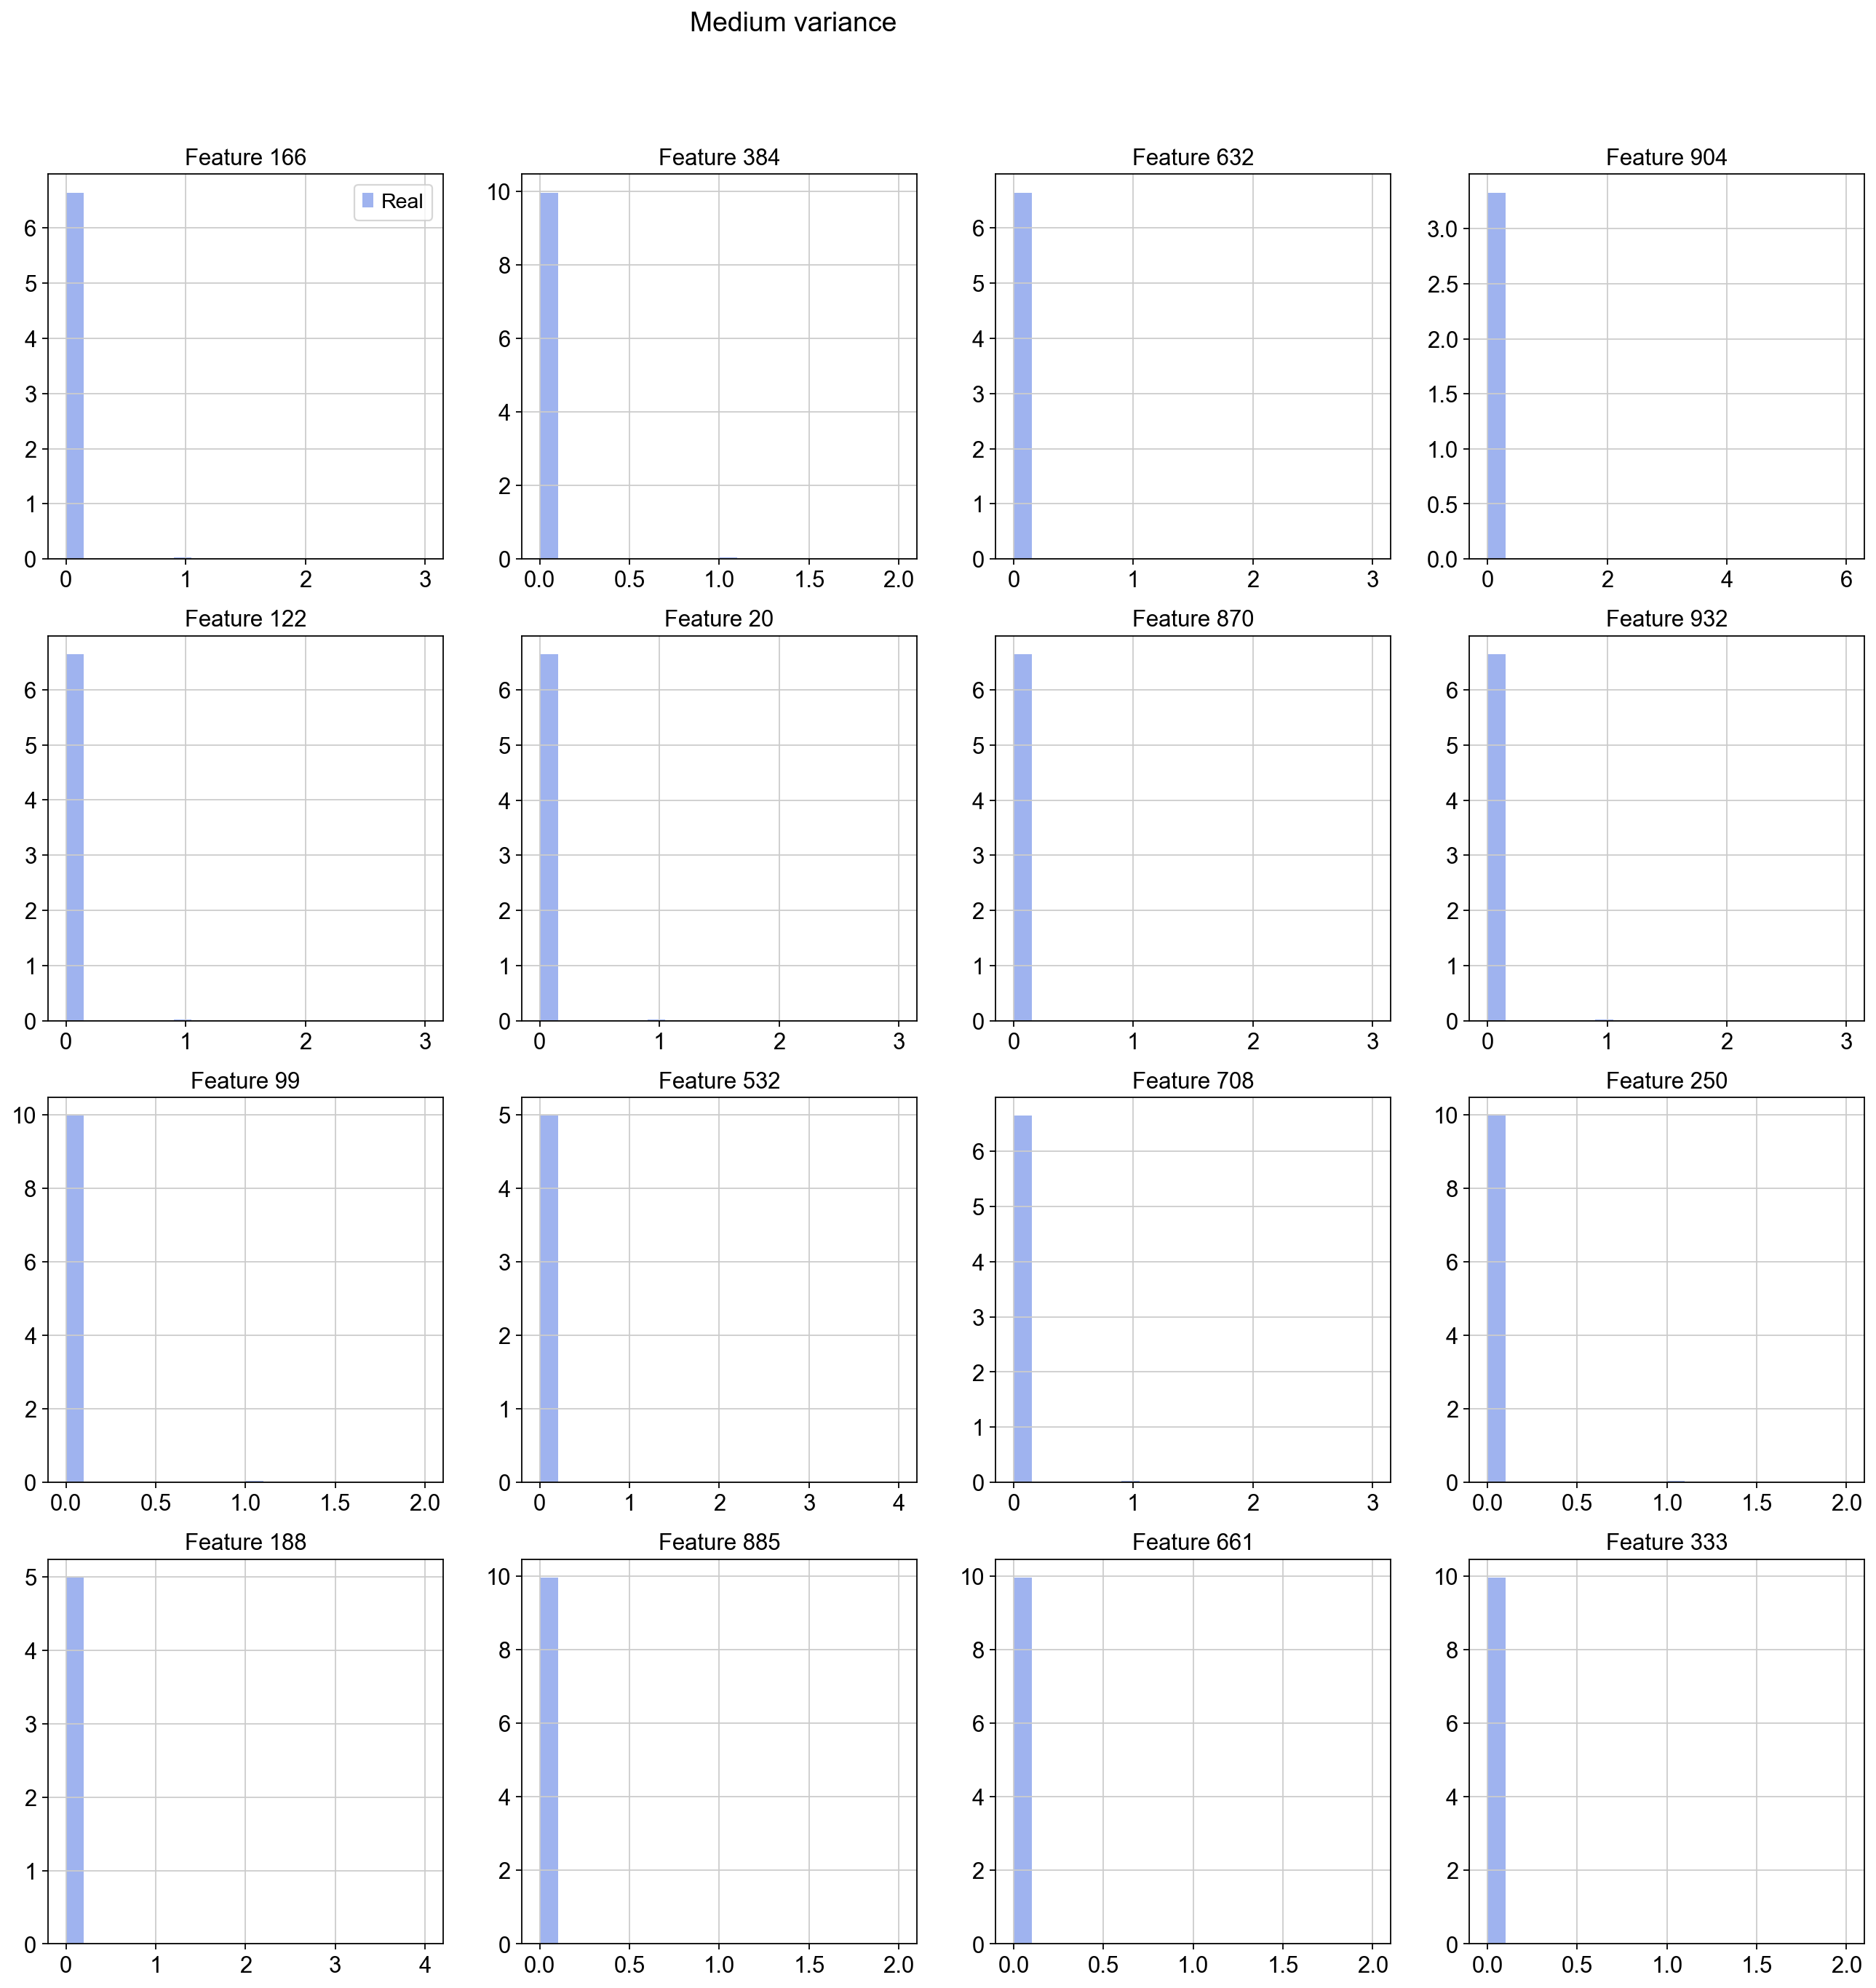

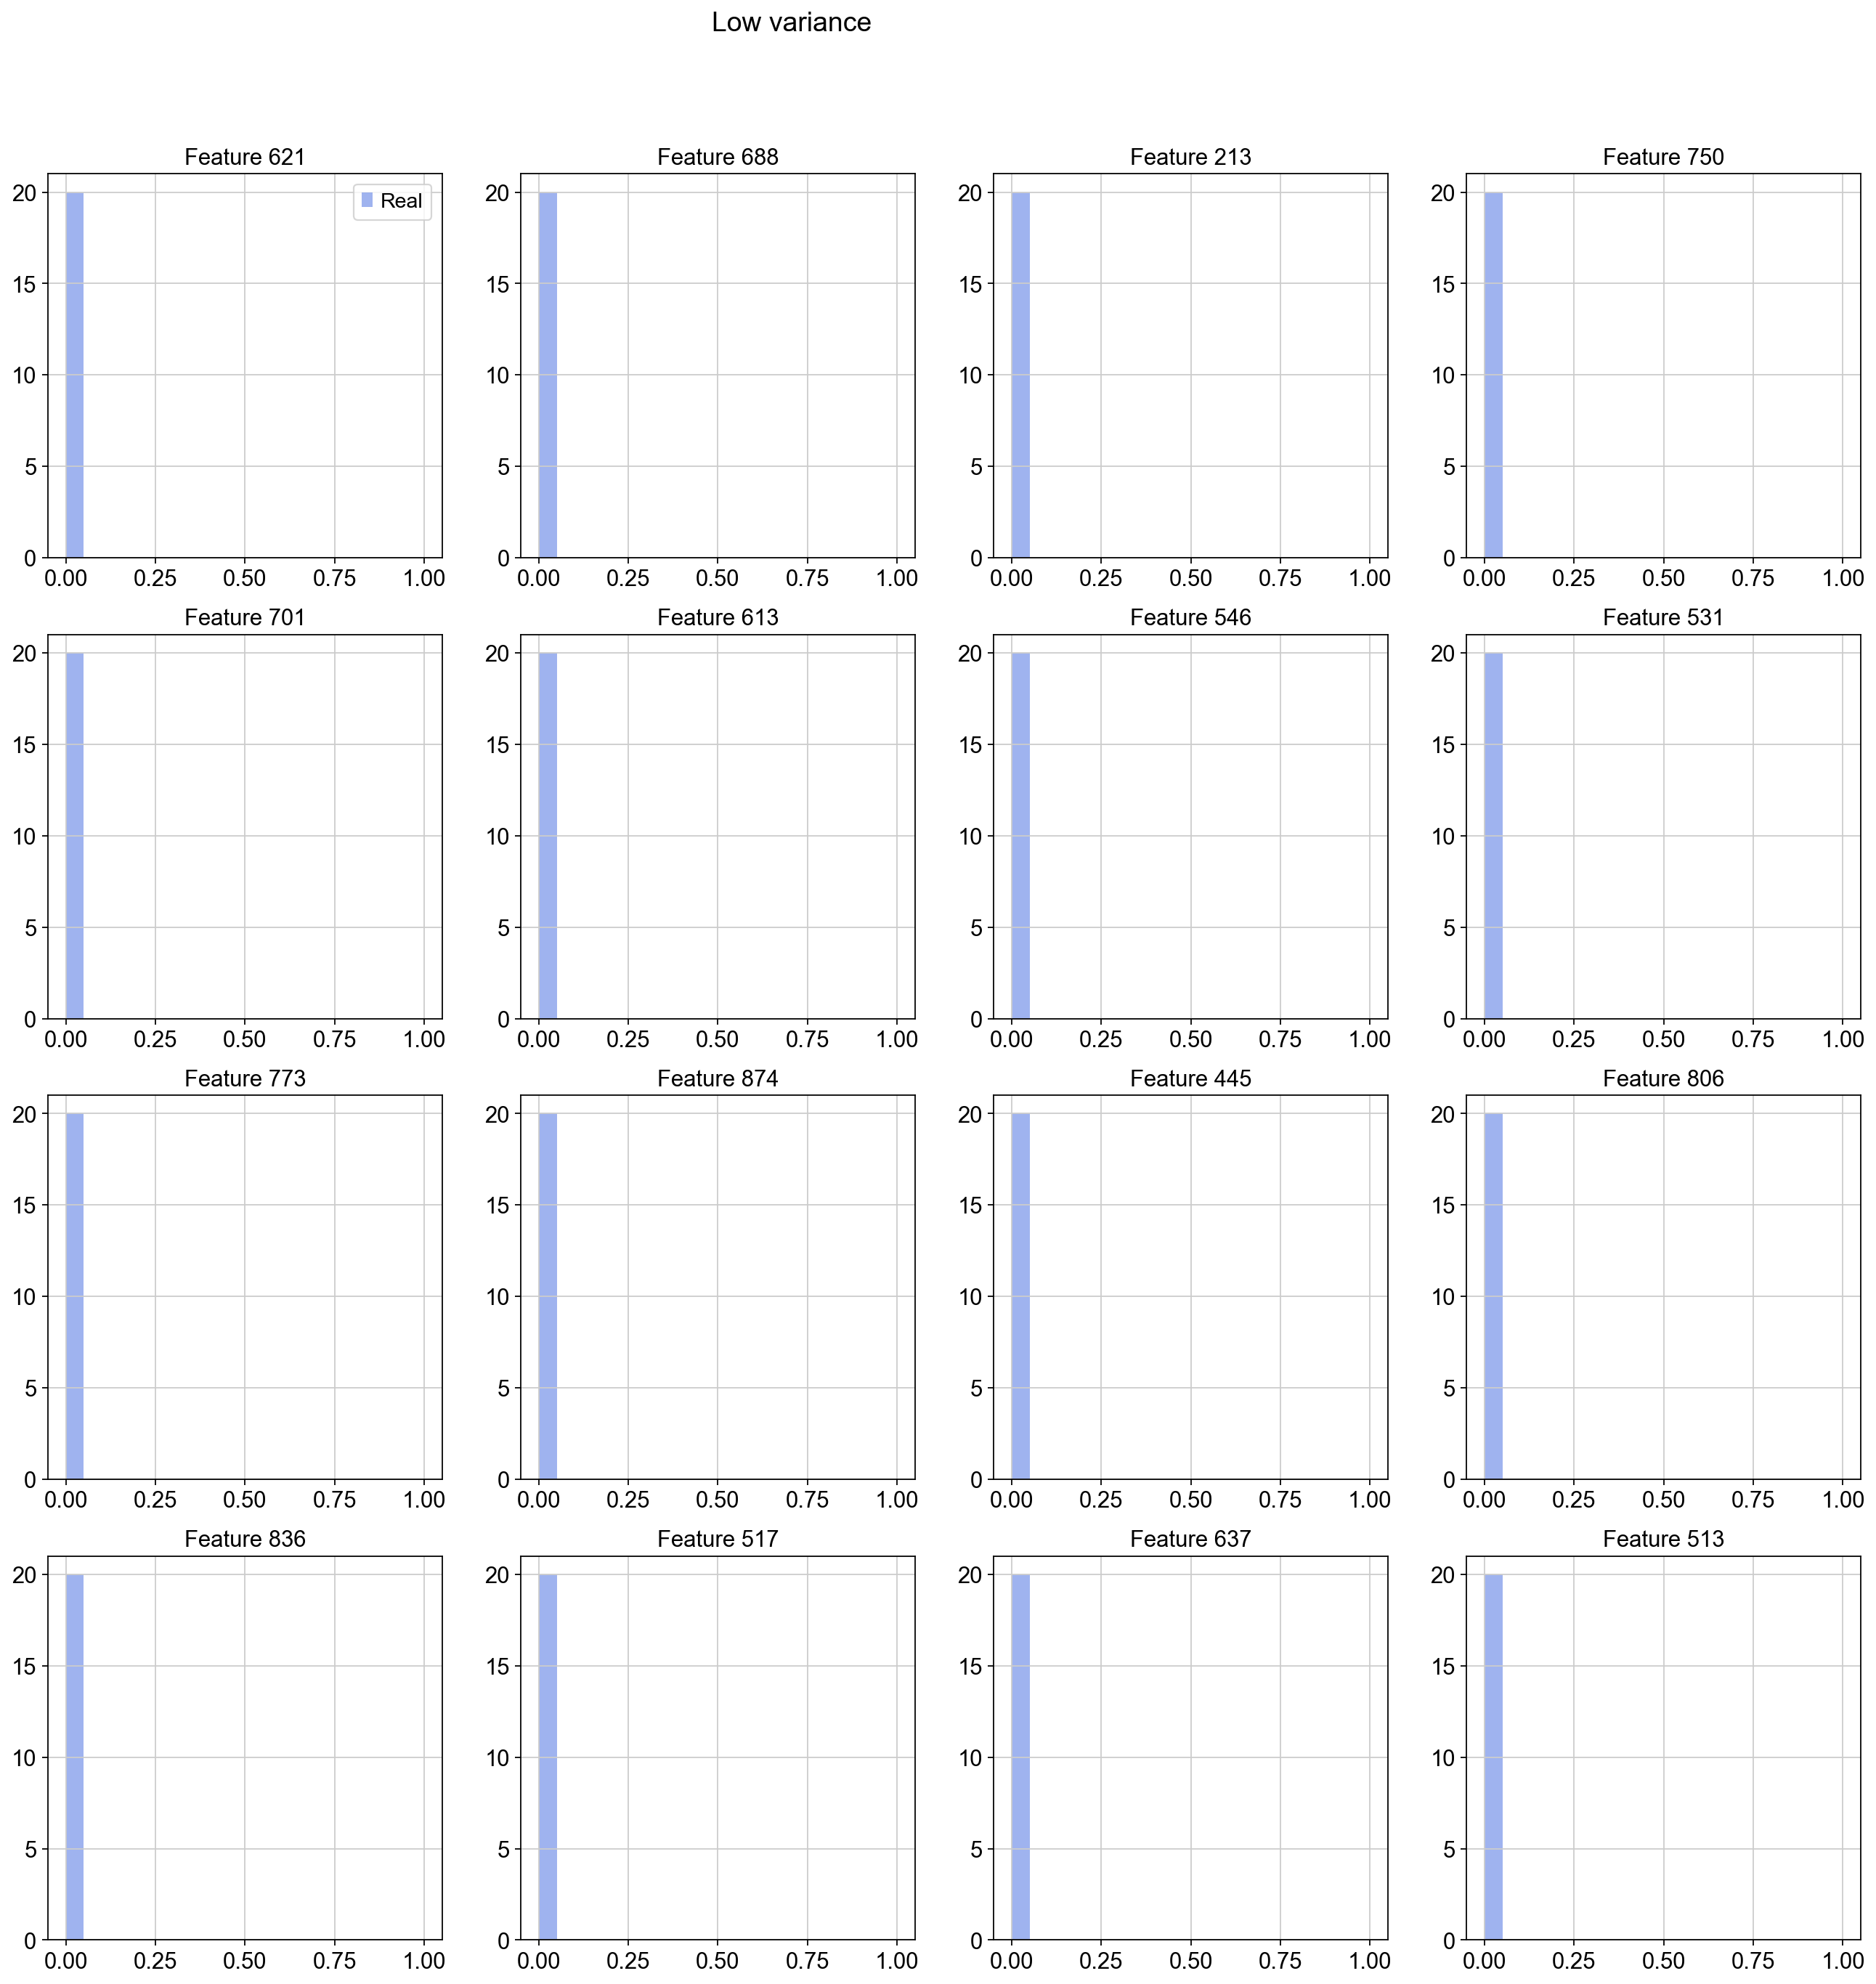

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
ax[0].hist(np.sum(raw_counts == 0, axis=0) / raw_counts.shape[0], bins=30)
ax[0].set_title("Proportion of zeros")
ax[1].hist(np.std(raw_counts, axis=0), bins=30)
ax[1].set_title("Standard deviations of features")
plt.show()

inds = np.flip(np.argsort(np.std(raw_counts, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = raw_counts[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()

### Identify marker genes in cell-type clusters

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


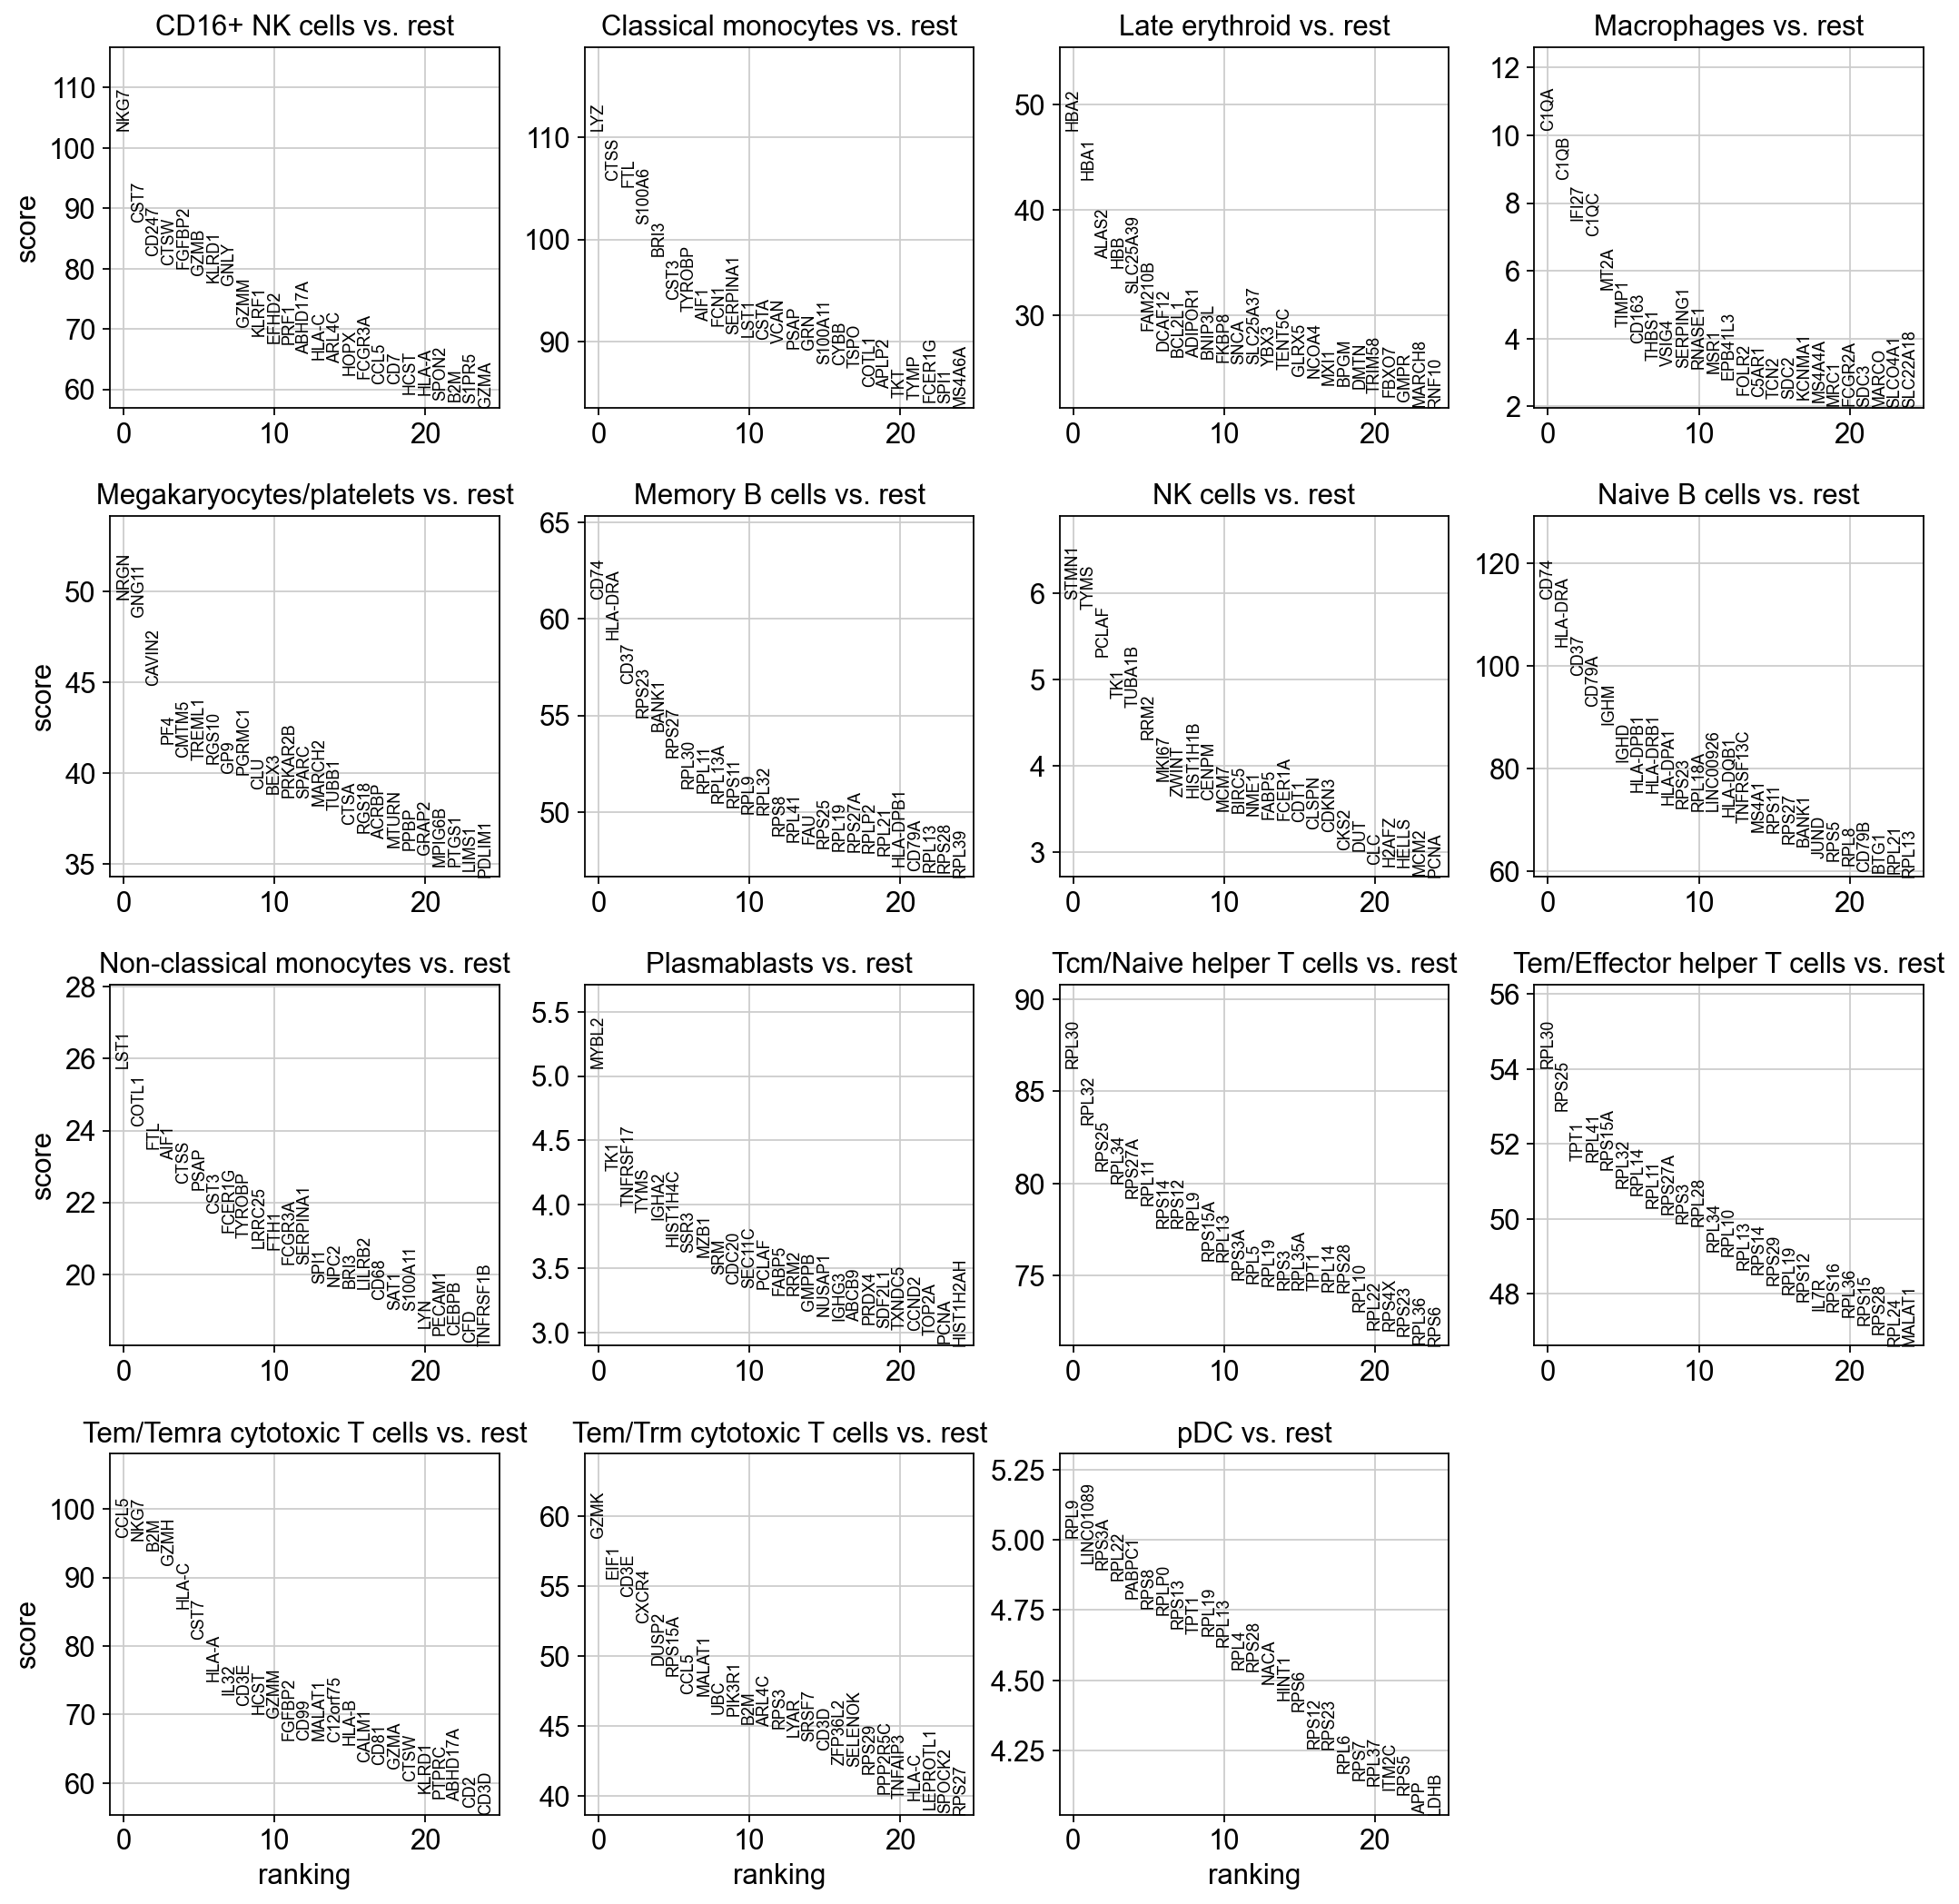

In [22]:
sc.tl.rank_genes_groups(adata, "cell_cluster", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [23]:
inferred_marker_genes = []
names = adata.uns["rank_genes_groups"]["names"]
scores = adata.uns["rank_genes_groups"]["scores"]
for cell_type in names.dtype.names:
    inds = np.argsort(scores[cell_type])[-25:]
    inferred_marker_genes.append(np.array(names[cell_type][inds]))
inferred_marker_genes_collated = np.unique(np.concatenate(inferred_marker_genes))

### Extract genes of interest from imported data

In [24]:
imported_marker_genes = []
for t in cluster_marker_tables:
    imported_marker_genes.append(np.array(t["gene"]))
imported_marker_genes = np.unique(np.concatenate(imported_marker_genes))

go_term_genes = []
for k, t in go_term_gene_tables.items():
    if k == "top_related_terms":
        continue
    st = t["Genes"]
    if st.empty:
        continue
    genes = [s.strip() for s in np.concatenate([
        c.split(",") for c in st
    ])]
    go_term_genes.append(genes)
go_term_genes = np.unique(np.concatenate(go_term_genes))

a = cluster_module_genes_table.replace(np.nan, "-").to_numpy().ravel()
cluster_module_genes = np.unique(a[a != "-"])

tcell_genes = []
for t in tcell_genes_tables:
    tcell_genes.append(np.array(t["gene"]))
tcell_genes = np.unique(np.concatenate(tcell_genes))

a = cm_genes_table.replace(np.nan, "-").to_numpy().ravel()
cm_genes = np.unique(a[a != "-"])

covid_genes = []
for t in covid_genes_tables.values():
    covid_genes.append(np.array(t["gene"]))
covid_genes = np.unique(np.concatenate(covid_genes))

imported_genes = np.unique(np.concatenate([
    imported_marker_genes, go_term_genes, cluster_module_genes, tcell_genes, cm_genes, covid_genes
]))

### Filter out genes other than those of interest

In [25]:
mask = np.isin(adata.var["gene_ids"].index, np.unique(np.concatenate([imported_genes, inferred_marker_genes_collated, text_genes])))
adata = adata[:, mask]
adata

View of AnnData object with n_obs × n_vars = 37102 × 280
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_cluster', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'neighbors', 'leiden', 'dendrogram_cell_cluster', 'hvg', 'pca', 'cell_cluster_colors', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

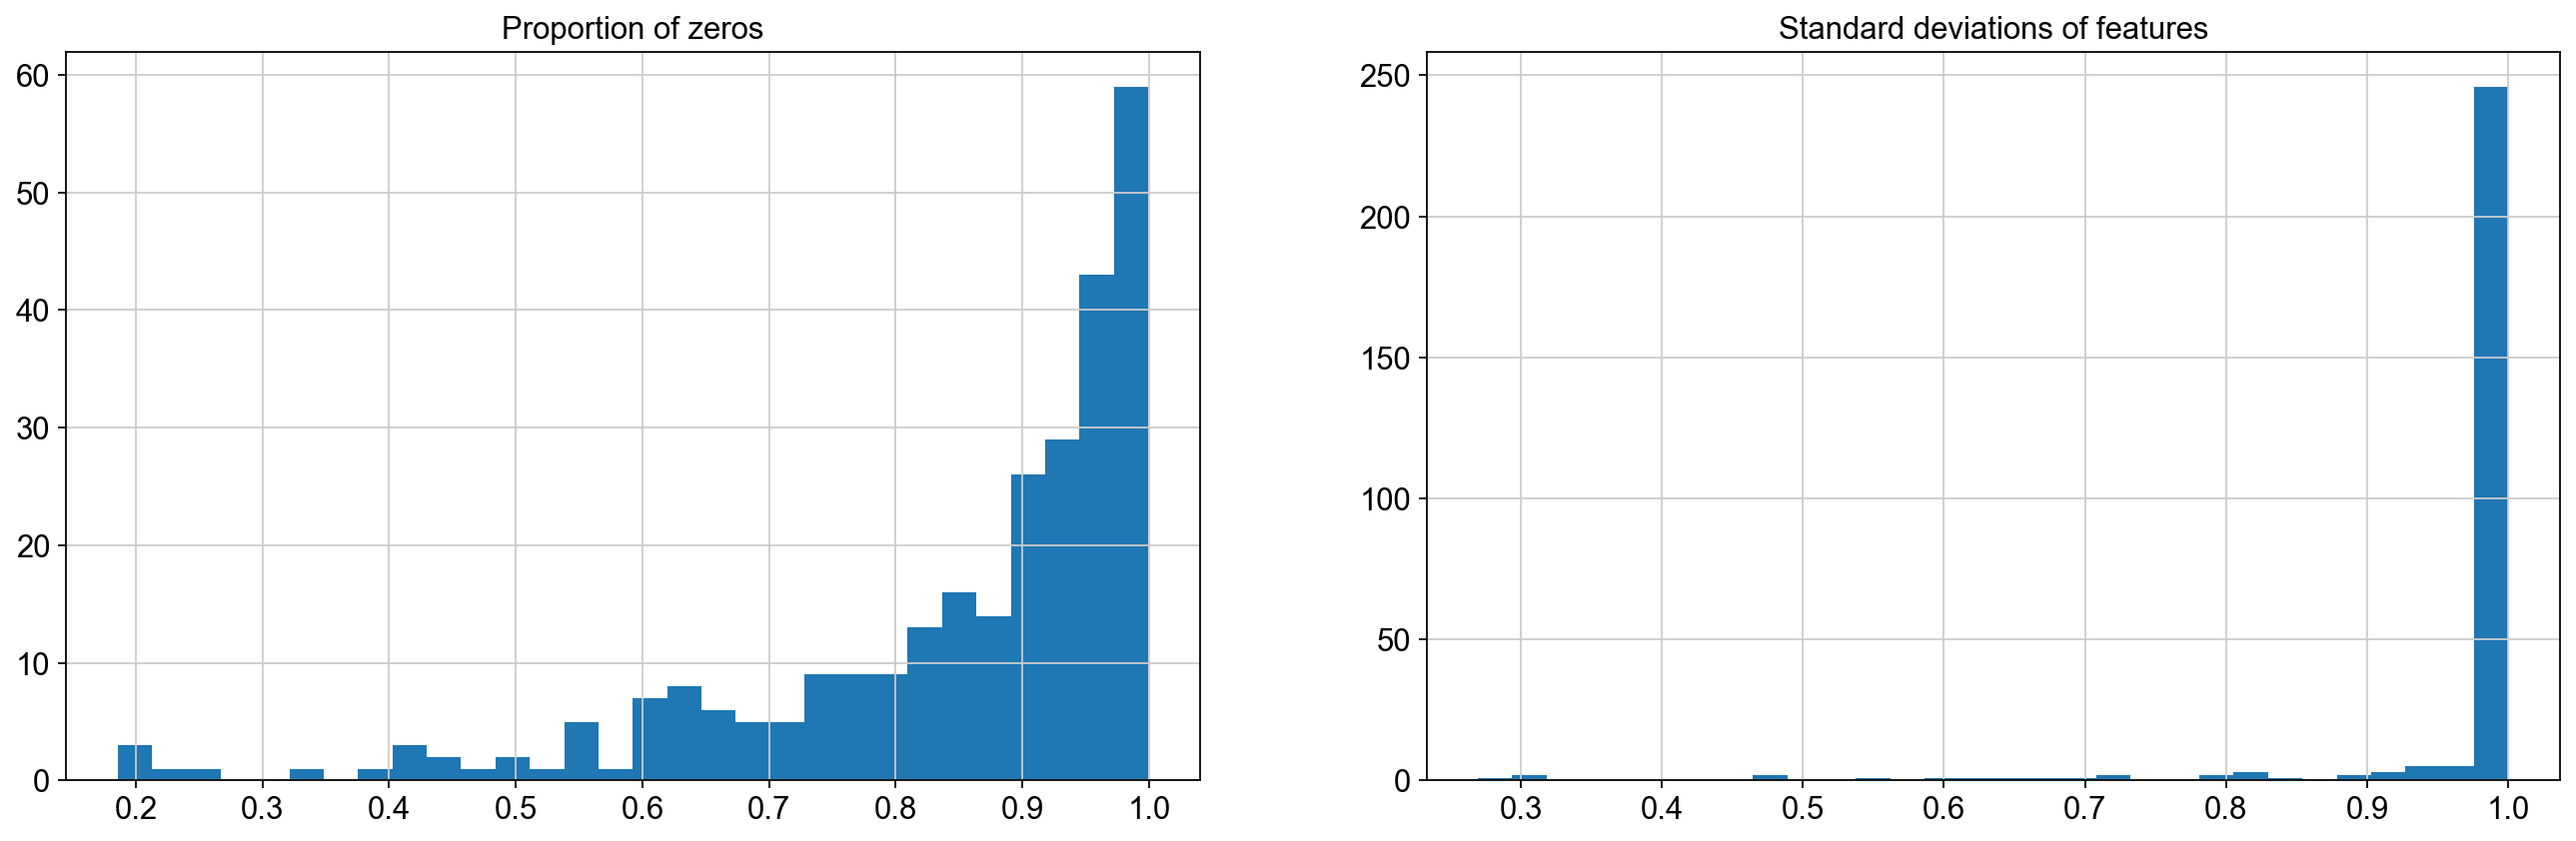

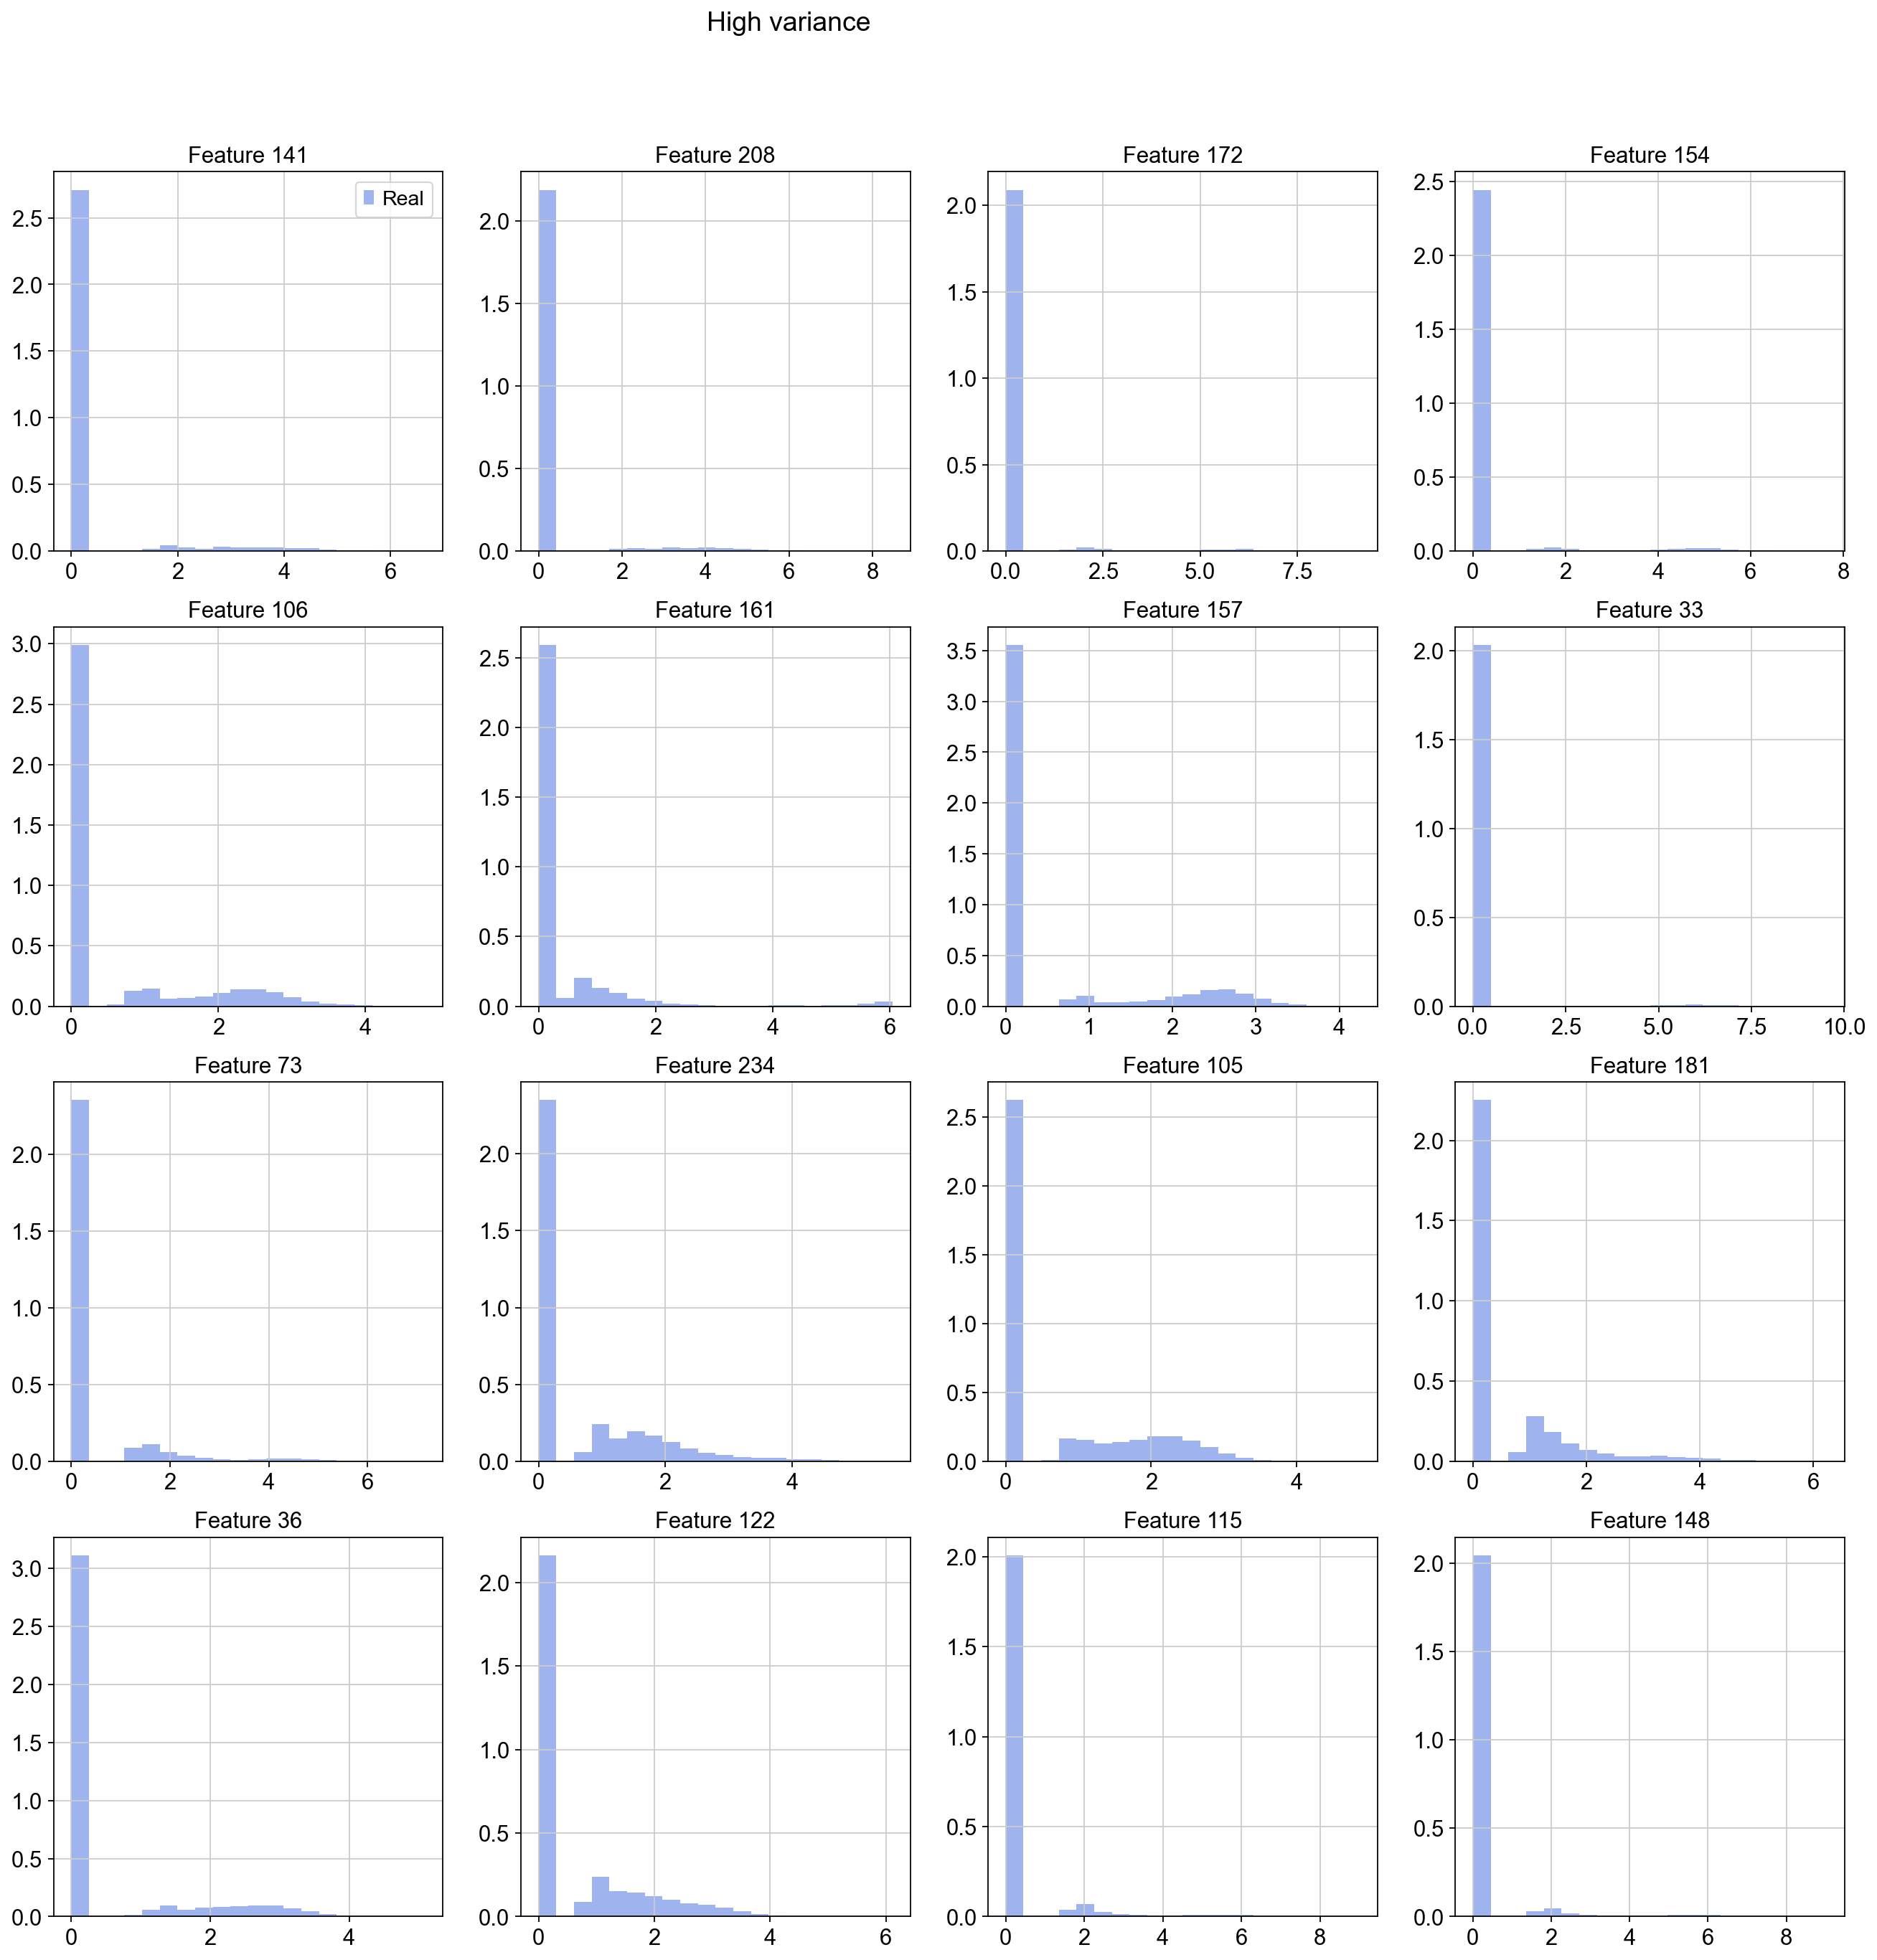

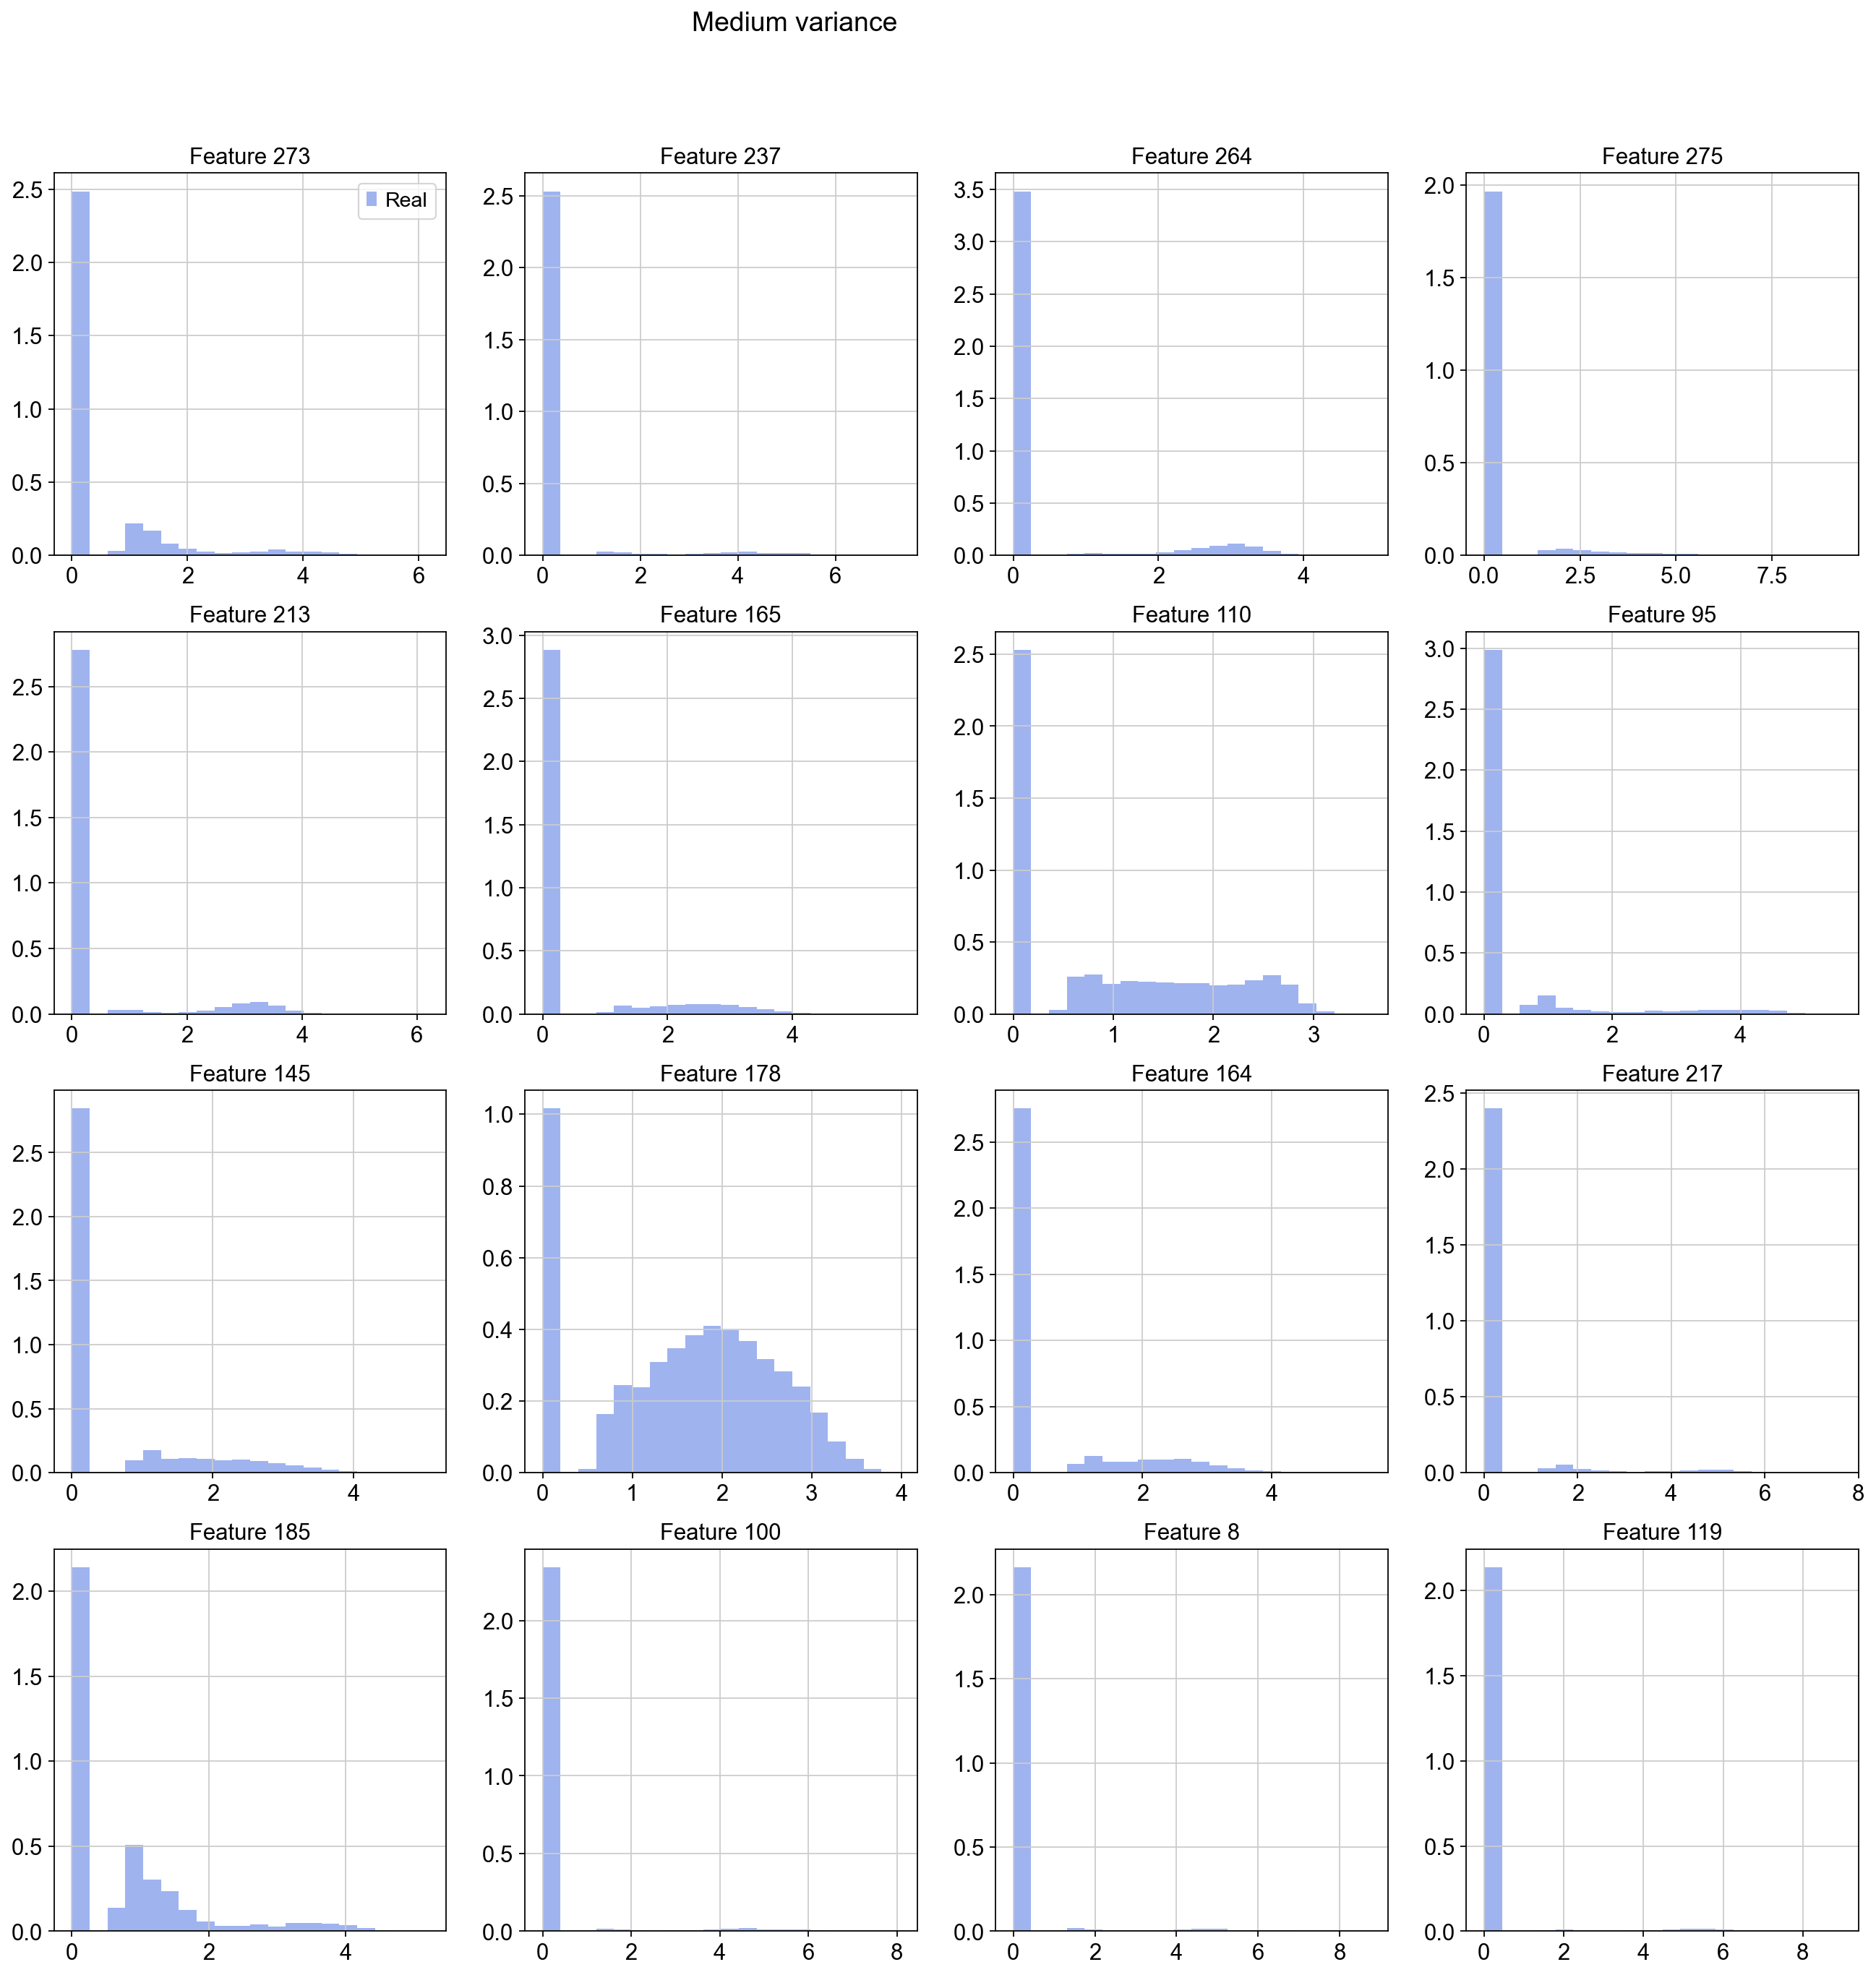

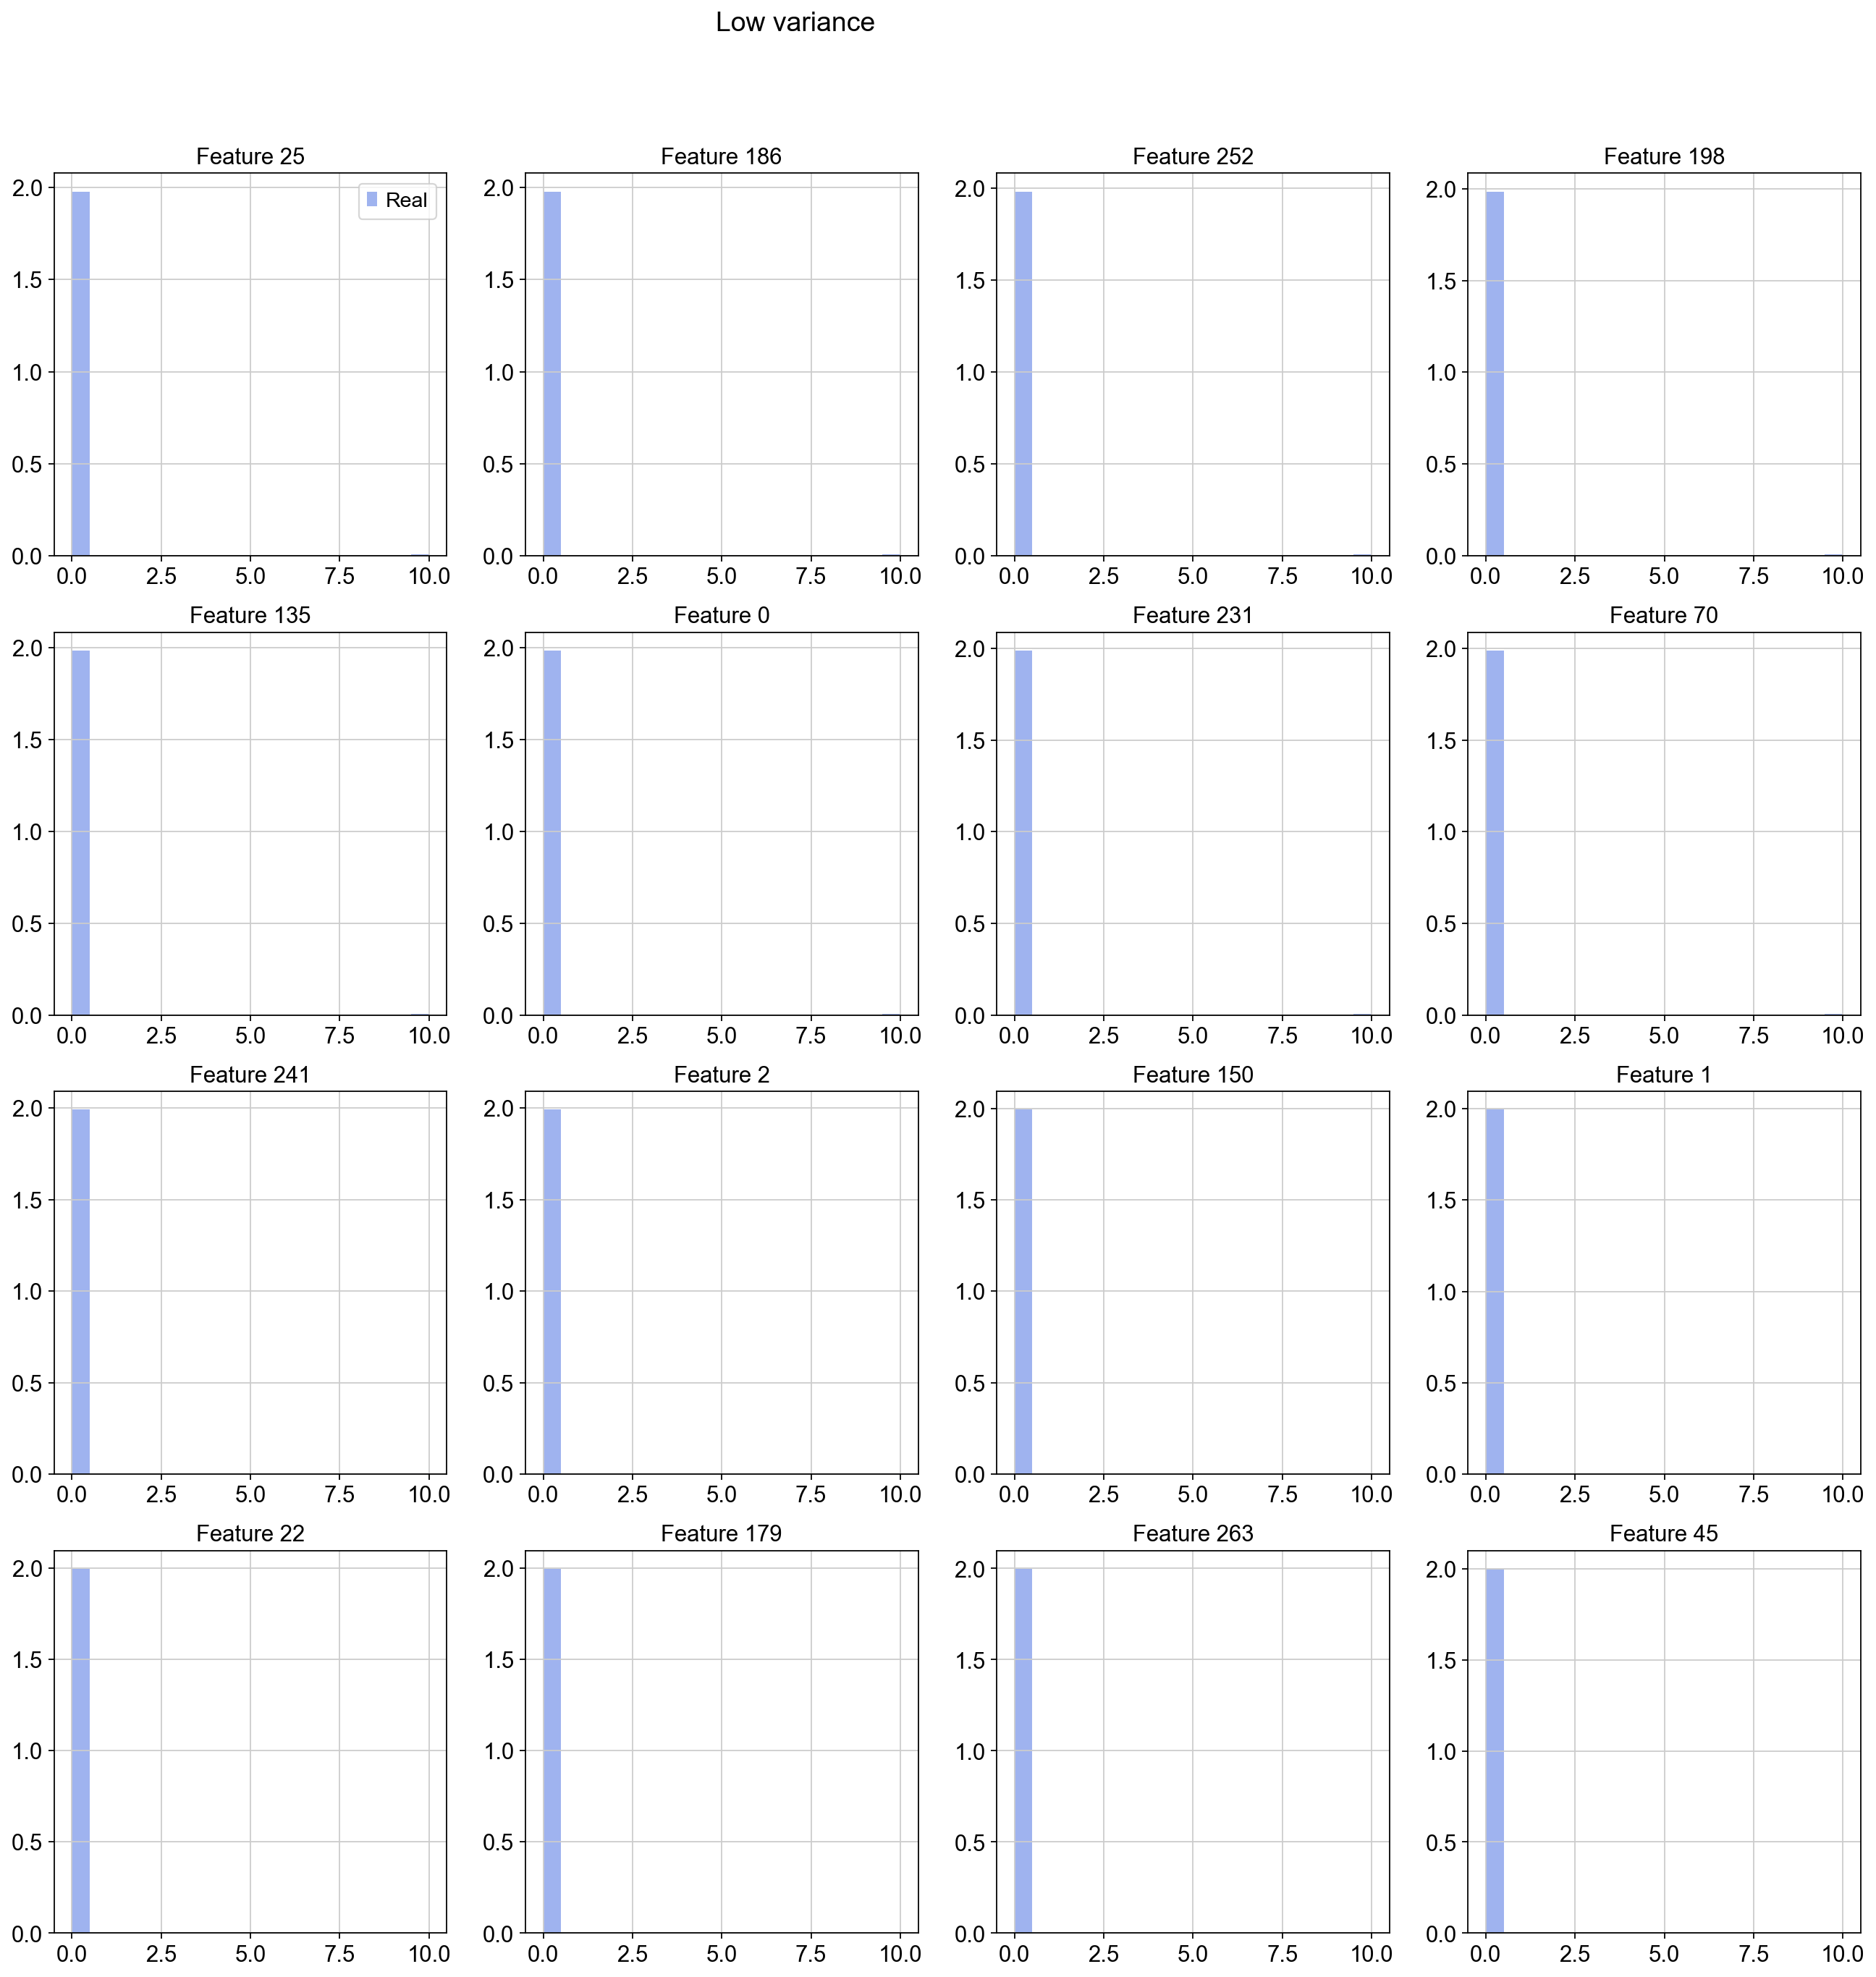

In [26]:
x = adata.X.toarray()

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
ax[0].hist(np.sum(x == 0, axis=0) / raw_counts.shape[0], bins=30)
ax[0].set_title("Proportion of zeros")
ax[1].hist(np.std(x, axis=0), bins=30)
ax[1].set_title("Standard deviations of features")
plt.show()

inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()

### Train model for dimensionality reduction

In [45]:
adata = adata.copy()
scvi.model.LinearSCVI.setup_anndata(adata)
model = scvi.model.LinearSCVI(adata, n_latent=200)

In [46]:
model.train(max_epochs=500, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [17:51<00:00,  2.17s/it, loss=127, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [17:51<00:00,  2.14s/it, loss=127, v_num=1]


<AxesSubplot:xlabel='epoch'>

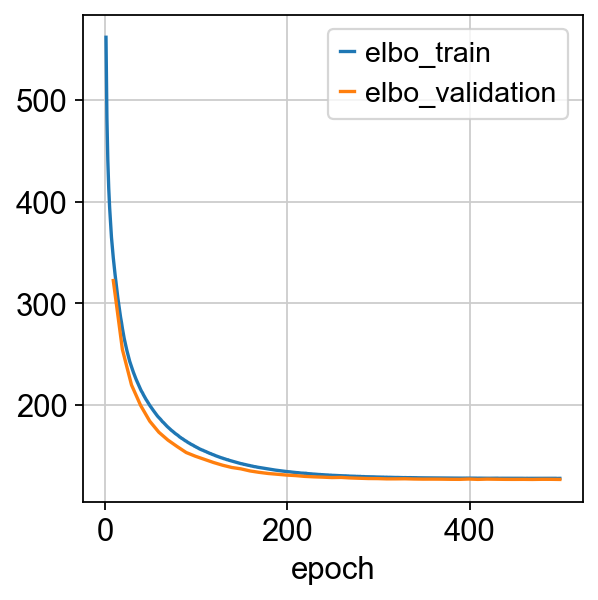

In [47]:
# Examine training curves
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [48]:
# Save latent-space representations
z = model.get_latent_representation()
adata.obsm["latent"] = z

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


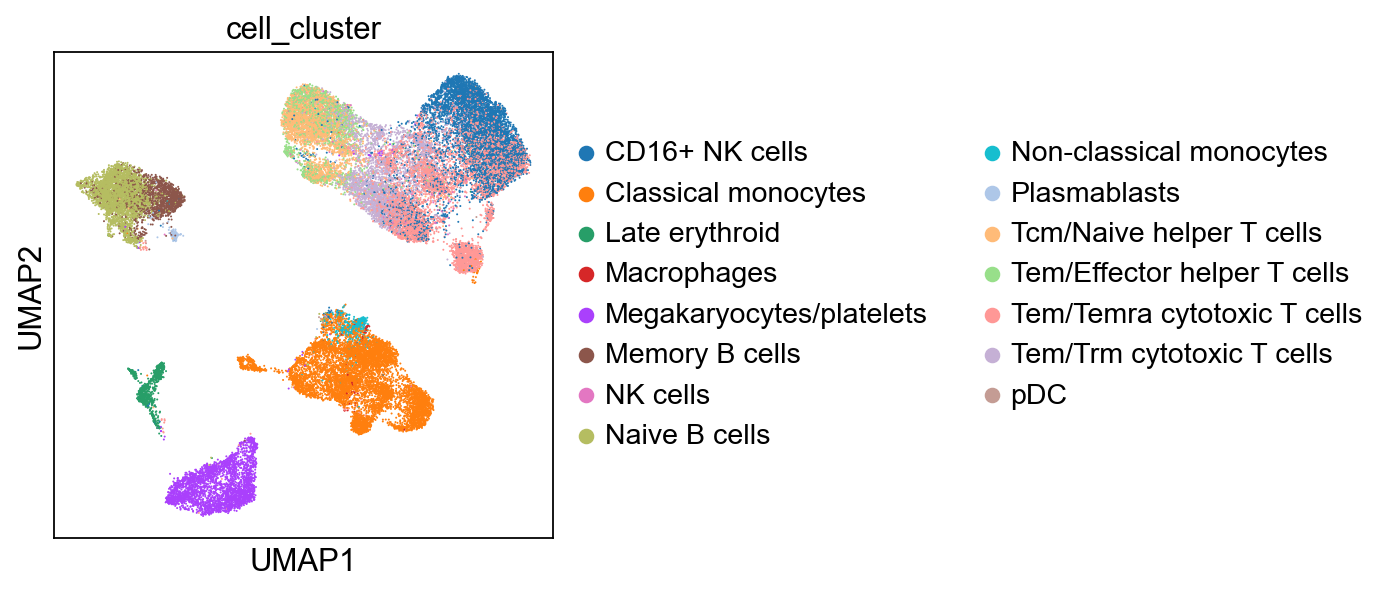

In [49]:
# View cell clusters in latent space
sc.pp.neighbors(adata, use_rep="latent", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color="cell_cluster")

In [50]:
# Save model
model.save(vae_model_path, save_anndata=True, overwrite=True)

INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae/model.pt already downloaded                                                     


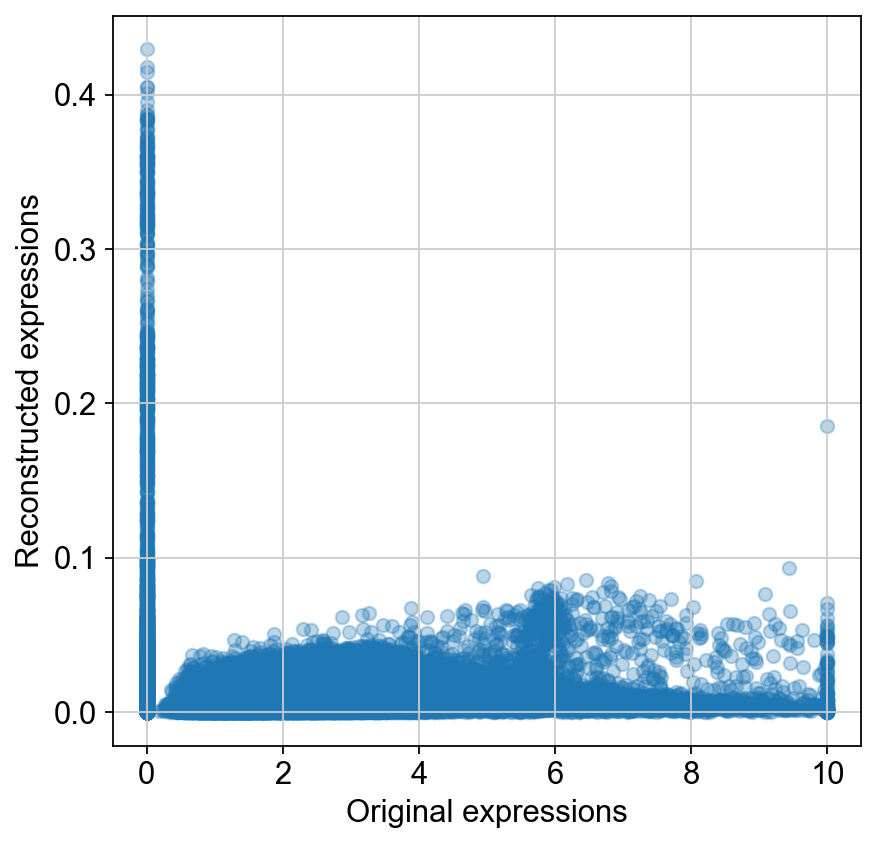

Overall Pearson correlation: 0.2615


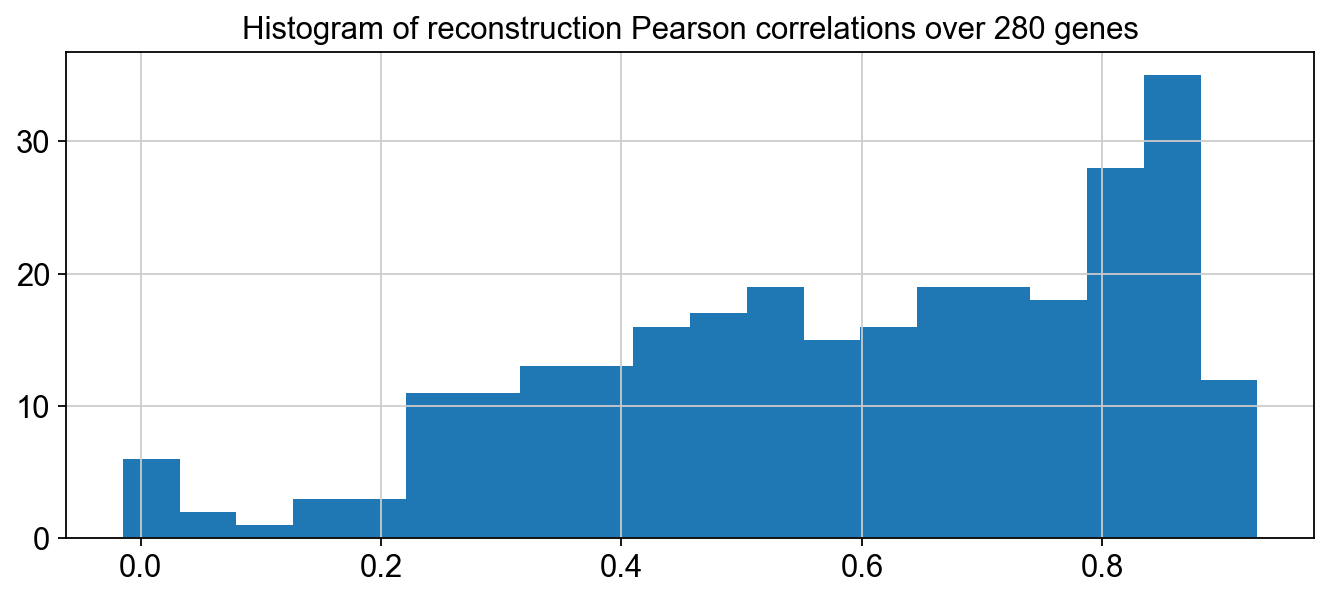

In [33]:
# Load the model and verify the quality of the reconstructions
model = scvi.model.LinearSCVI.load(vae_model_path)

batch_size = 1024

# Encode
x = adata.X.toarray()[:batch_size]
enc_pred = model.module.inference(
    torch.tensor(x).cuda().float(), torch.ones(batch_size, device="cuda")
)
z = enc_pred["qz"].loc.detach().cpu().numpy()

# Decode
dec_pred = model.module.generative(
    torch.tensor(z).cuda(),
    torch.ones((batch_size, 1), device="cuda"), torch.zeros((batch_size, 1), device="cuda")
)
x_hat = dec_pred["px"].scale.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.ravel(x), np.ravel(x_hat), alpha=0.3)
ax.set_xlabel("Original expressions")
ax.set_ylabel("Reconstructed expressions")
plt.show()
print("Overall Pearson correlation: %.4f" % scipy.stats.pearsonr(np.ravel(x), np.ravel(x_hat))[0])

fig, ax = plt.subplots(figsize=(10, 4))
corrs = [scipy.stats.pearsonr(x[:, i], x_hat[:, i])[0] for i in range(x.shape[1])]
ax.hist(corrs, bins=20)
ax.set_title("Histogram of reconstruction Pearson correlations over %d genes" % x.shape[1])
plt.show()

### Write out data file

In [34]:
# Save results
adata.write(out_path)

In [35]:
# Map each cell-cluster name to a numerical ID
cell_clusters, counts = np.unique(adata.obs["cell_cluster"], return_counts=True)
inds = np.flip(np.argsort(counts))
cell_clusters = cell_clusters[inds]
cell_cluster_dict = {c : i for i, c in enumerate(cell_clusters)}
adata.obs["cell_cluster_id"] = adata.obs["cell_cluster"].apply(lambda c: cell_cluster_dict[c])

In [36]:
with h5py.File(out_path, "w") as f:
    f.create_dataset("x", data=adata.X.toarray(), compression="gzip")
    f.create_dataset("x_latent", data=adata.obsm["latent"], compression="gzip")
    f.create_dataset("gene_names", data=np.array(adata.var["gene_ids"].index), compression="gzip")
    f.create_dataset("gene_ids", data=np.array(adata.var["gene_ids"]), compression="gzip")
    f.create_dataset("cell_id", data=np.array(adata.obs["cell_cluster"].index), dtype=h5py.string_dtype(encoding="ascii"), compression="gzip")
    f.create_dataset("cell_cluster_id", data=np.array(adata.obs["cell_cluster_id"]).astype(int), compression="gzip")
    f.create_dataset("cell_cluster_name", data=np.array(adata.obs["cell_cluster"]), dtype=h5py.string_dtype(encoding="ascii"), compression="gzip")
    mg = f.create_group("marker_genes")
    for i, genes in enumerate(inferred_marker_genes):
        mg.create_dataset(str(i), data=genes, dtype=h5py.string_dtype(encoding="ascii"), compression="gzip")